# Ice Modeling



In [1]:
import numpy as np
import mysg # Tom Robitaille's YSO grid tool
from astropy.table import Table
from astropy import units as u, constants
import pylab as pl
import requests

from icemodels import absorbed_spectrum, absorbed_spectrum_Gaussians, convsum, fluxes_in_filters, load_molecule, atmo_model, molecule_data
del molecule_data['h2o_b'] # don't need double water

In [2]:
%matplotlib inline
import matplotlib
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'

In [3]:
import dust_extinction
from dust_extinction.averages import RRP89_MWGC, CT06_MWGC, F11_MWGC, G21_MWAvg
from dust_extinction.parameter_averages import CCM89

In [4]:
from astroquery.svo_fps import SvoFps

In [5]:
jfilts = SvoFps.get_filter_list('JWST')
jfilts.add_index('filterID')

In [6]:
ext = CT06_MWGC()
ext([1.3, 10, 27]*u.um)

array([0.27675751, 0.14616   , 0.060256  ])

In [7]:
label_map = {'ch3oh': 'CH$_3$OH',
             'co2': 'CO$_2$',
             'ch4': 'CH$_4$',
             'co': 'CO',
             'h2o': 'H$_2$O',
             'nh3': 'NH$_3$',
            }

In [8]:
from astroquery.svo_fps import SvoFps
from astropy import table
filter_data_nircam = SvoFps.get_filter_list('JWST', instrument="NIRCam")
filter_data_miri = SvoFps.get_filter_list('JWST', instrument="MIRI")
filter_data_jwst = table.vstack([filter_data_nircam, filter_data_miri])
filter_data_spitzer_irac = SvoFps.get_filter_list('Spitzer', instrument='IRAC')
filter_data_spitzer_mips = SvoFps.get_filter_list('Spitzer', instrument='MIPS')
filter_data_spitzer = table.vstack([filter_data_spitzer_mips, filter_data_spitzer_irac])


for filter_data in (filter_data_jwst, filter_data_spitzer):
    filter_data.add_index('filterID')
    flxd = filter_data['filterID'] # TODO: might need to change this to only select the filters we're using below
    filter_wavelengths = [filter_data.loc[filterid]['WavelengthCen'] for filterid in flxd]
    filter_widths = [filter_data.loc[filterid]['WidthEff'] for filterid in flxd]
    filter_wlmin = [filter_data.loc[filterid]['WavelengthMin'] for filterid in flxd]
    filter_wlmax = [filter_data.loc[filterid]['WavelengthMax'] for filterid in flxd]

filter_data = filter_data_jwst

In [9]:
distance = 8.5*u.kpc
av = 30

In [10]:
xarr = np.linspace(1, 28, 15000)*u.um

In [11]:
phx4000 = atmo_model(4000)

In [12]:
nh3_consts = load_molecule('nh3')

In [13]:
co2_consts = load_molecule('co2')

In [14]:
# how much column do we need to get a nondetection in F300m?
# SNR=480 for a G0V at A_K=2.5 with mag_F410M=20
absorbed_spectrum([1e18,3e18]*u.cm**-2, load_molecule('h2o'), spectrum=[1]*u.Jy, xarr=[3.0]*u.um)

<Quantity [0.24652858, 0.0149831 ] Jy>

(1.0, 25)

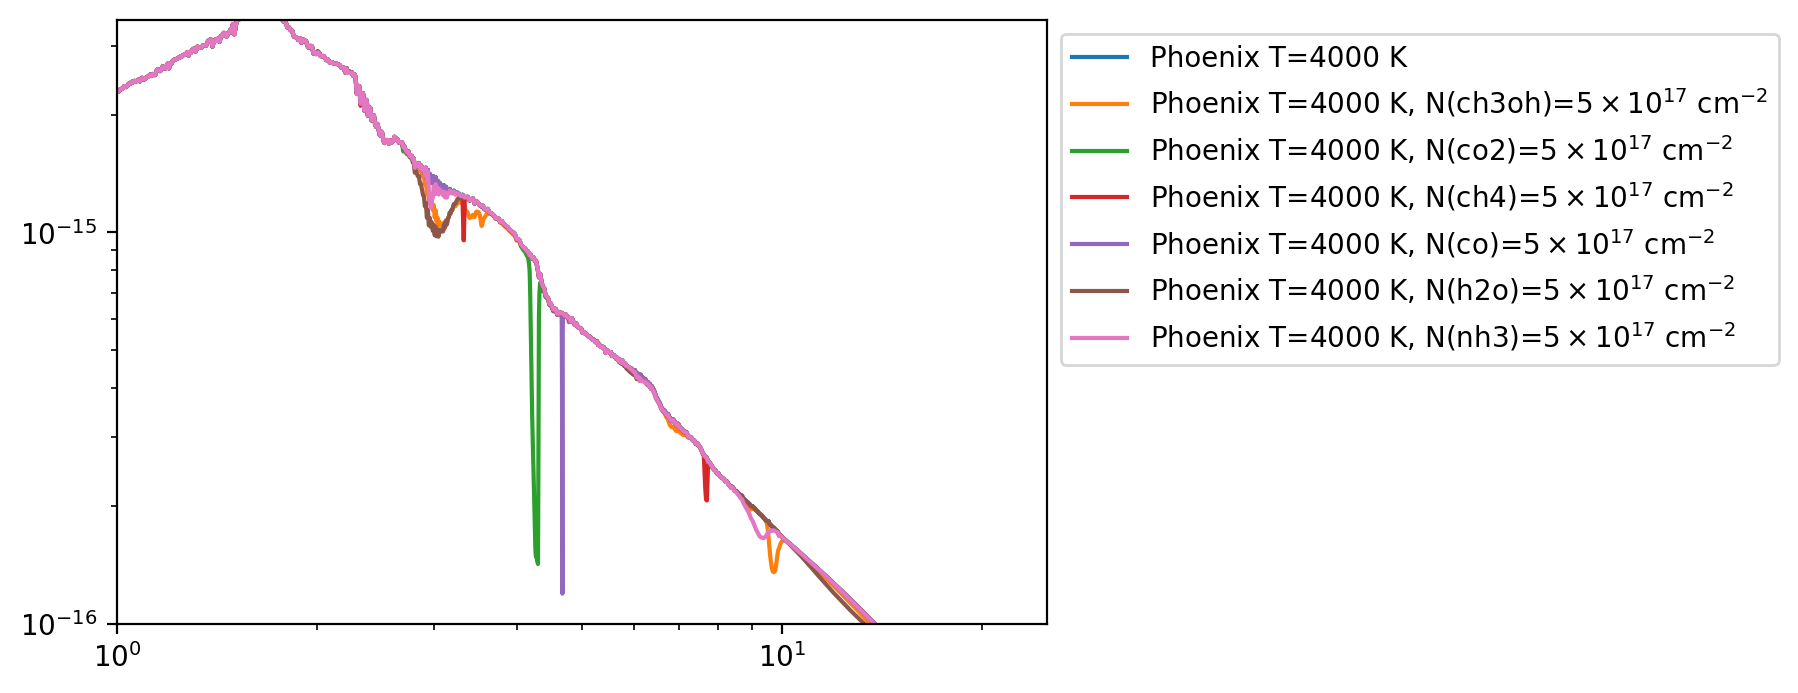

In [15]:
pl.figure(dpi=200)
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()), phx4000['fnu'], label="Phoenix T=4000 K")

for molecule, md in molecule_data.items():
    #print(molecule, md)
    consts = load_molecule(molecule)
    spec = absorbed_spectrum(5e17*u.cm**-2, consts, molecular_weight=md['molwt'])
    pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
              spec,
              label=f"Phoenix T=4000 K, N({molecule})=$5\\times10^{{17}}$ cm$^{{-2}}$")

pl.legend(bbox_to_anchor=[1.0, 1.0])
pl.ylim(1e-16, 3.5e-15)
pl.xlim(1.0, 25)

In [16]:
from icemodels.gaussian_model_components import *

(1.0, 25)

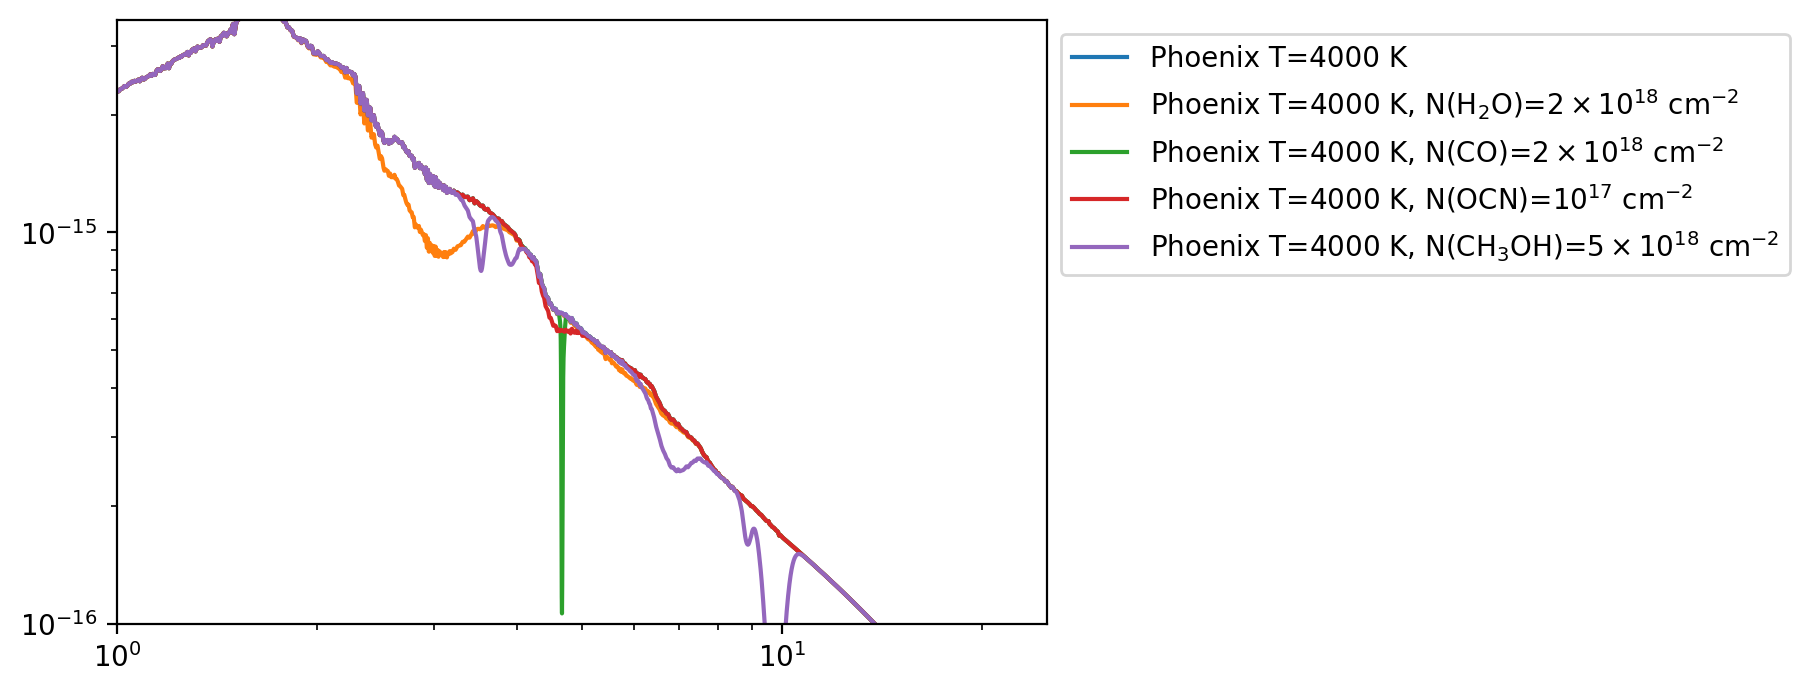

In [17]:
pl.figure(dpi=200)

pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()), phx4000['fnu'], label="Phoenix T=4000 K")
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
          absorbed_spectrum_Gaussians(2e18*u.cm**-2, water_ice_centers, water_ice_widths, water_ice_bandstrengths),
          label="Phoenix T=4000 K, N(H$_2$O)=$2 \\times 10^{18}$ cm$^{-2}$")
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
          absorbed_spectrum_Gaussians(2e18*u.cm**-2, co_ice_centers, co_ice_widths, co_ice_bandstrengths),
          label="Phoenix T=4000 K, N(CO)=$2 \\times 10^{18}$ cm$^{-2}$")
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
          absorbed_spectrum_Gaussians(2e17*u.cm**-2, ocn_center, ocn_width, ocn_bandstrength),
          label="Phoenix T=4000 K, N(OCN)=10$^{17}$ cm$^{-2}$")
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
          absorbed_spectrum_Gaussians(5e18*u.cm**-2, methanol_ice_centers, methanol_ice_widths, methanol_ice_bandstrengths),
          label="Phoenix T=4000 K, N(CH$_3$OH)=$5\\times10^{18}$ cm$^{-2}$")
#pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
#          absorbed_spectrum2(5e18*u.cm**-2, co2_consts),
#          label="Phoenix T=4000 K, N(CO$_2$)=$5\\times10^{18}$ cm$^{-2}$")


pl.legend(bbox_to_anchor=[1,1])
pl.ylim(1e-16, 3.5e-15)
pl.xlim(1.0, 25)

(1.0, 25)

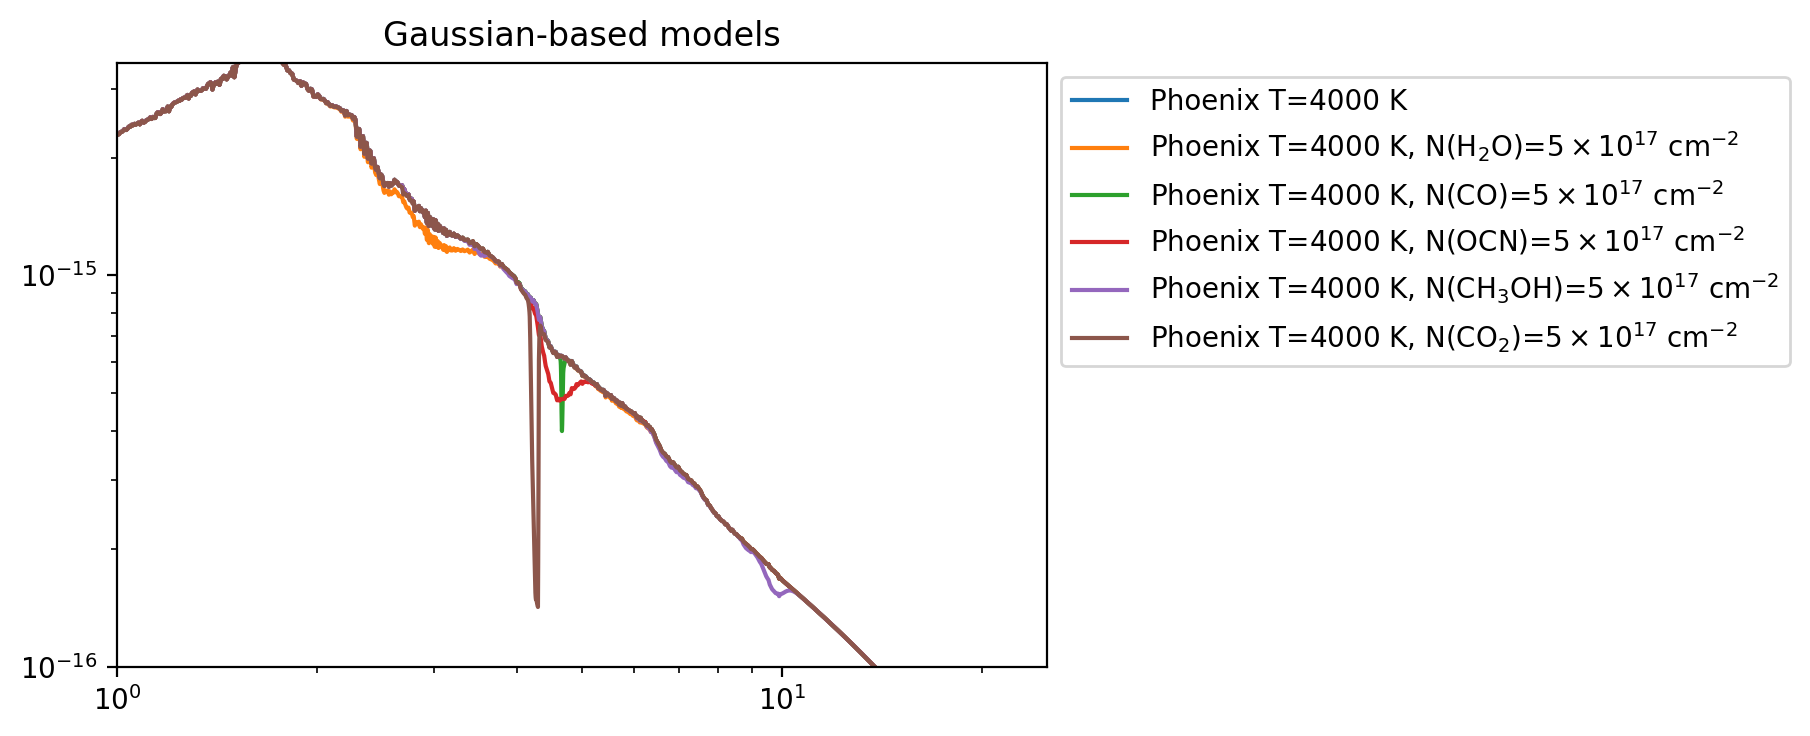

In [18]:
pl.figure(dpi=200)

pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()), phx4000['fnu'], label="Phoenix T=4000 K")
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
          absorbed_spectrum_Gaussians(5e17*u.cm**-2, water_ice_centers, water_ice_widths, water_ice_bandstrengths),
          label="Phoenix T=4000 K, N(H$_2$O)=$5 \\times 10^{17}$ cm$^{-2}$")
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
          absorbed_spectrum_Gaussians(5e17*u.cm**-2, co_ice_centers, co_ice_widths, co_ice_bandstrengths),
          label="Phoenix T=4000 K, N(CO)=$5 \\times 10^{17}$ cm$^{-2}$")
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
          absorbed_spectrum_Gaussians(5e17*u.cm**-2, ocn_center, ocn_width, ocn_bandstrength),
          label="Phoenix T=4000 K, N(OCN)=$5 \\times 10^{17}$ cm$^{-2}$")
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
          absorbed_spectrum_Gaussians(5e17*u.cm**-2, methanol_ice_centers, methanol_ice_widths, methanol_ice_bandstrengths),
          label="Phoenix T=4000 K, N(CH$_3$OH)=$5\\times10^{17}$ cm$^{-2}$")
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
          absorbed_spectrum(5e17*u.cm**-2, co2_consts),
          label="Phoenix T=4000 K, N(CO$_2$)=$5\\times10^{17}$ cm$^{-2}$")

pl.title("Gaussian-based models")
pl.legend(bbox_to_anchor=[1,1])
pl.ylim(1e-16, 3.5e-15)
pl.xlim(1.0, 25)

(1.0, 25)

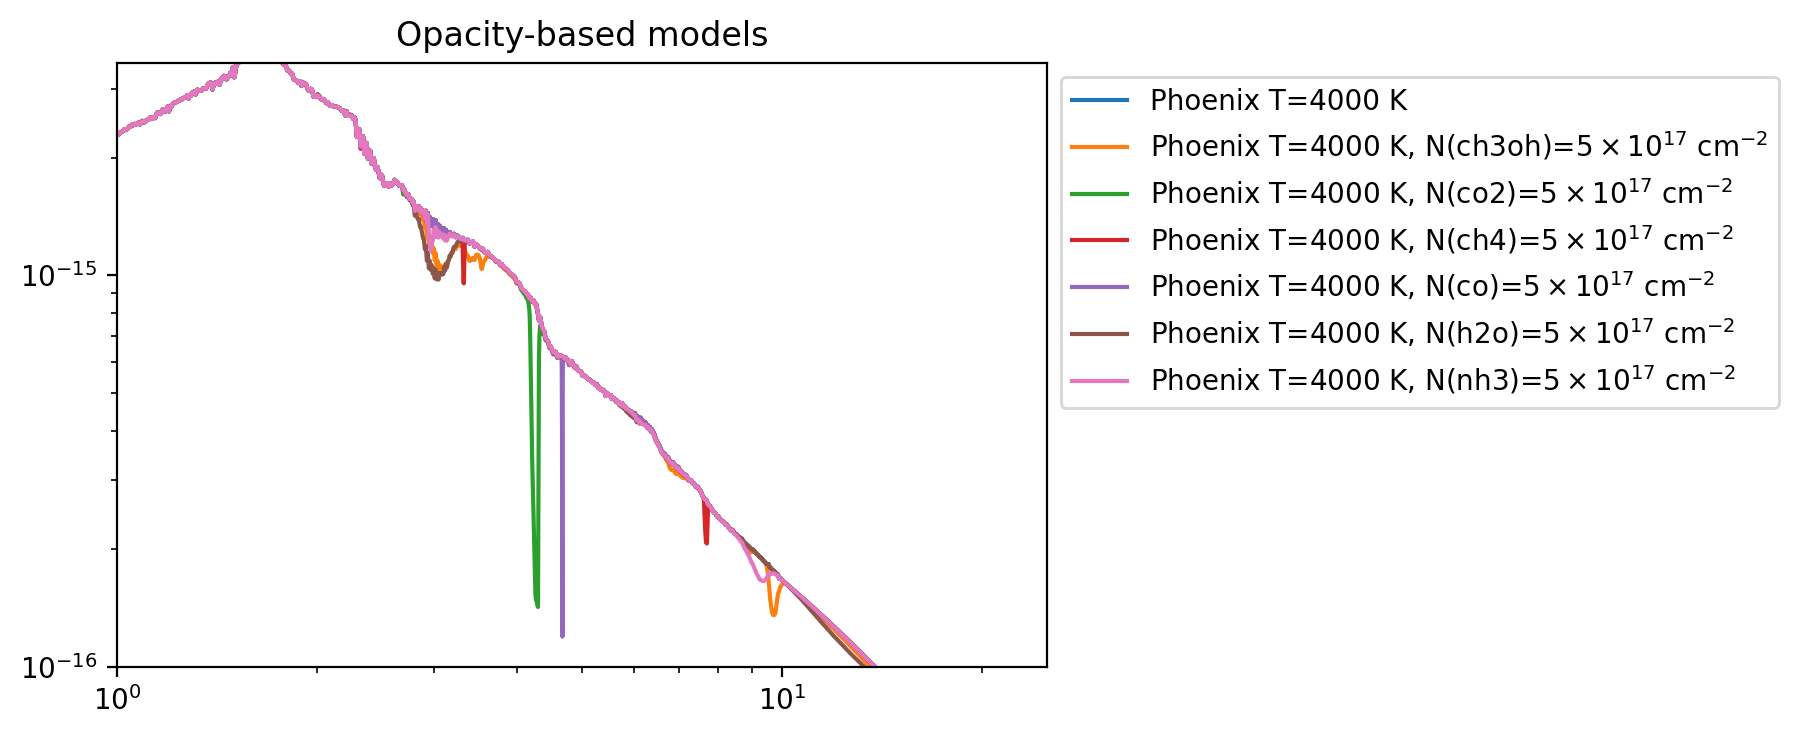

In [19]:
pl.figure(dpi=200)
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()), phx4000['fnu'], label="Phoenix T=4000 K")

for molecule, md in molecule_data.items():
    #print(molecule, md)
    consts = load_molecule(molecule)
    spec = absorbed_spectrum(5e17*u.cm**-2, consts, molecular_weight=md['molwt'])
    pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
              spec,
              label=f"Phoenix T=4000 K, N({molecule})=$5\\times10^{{17}}$ cm$^{{-2}}$")
pl.title("Opacity-based models")

pl.legend(bbox_to_anchor=[1.0, 1.0])
pl.ylim(1e-16, 3.5e-15)
pl.xlim(1.0, 25)

(1.0, 25)

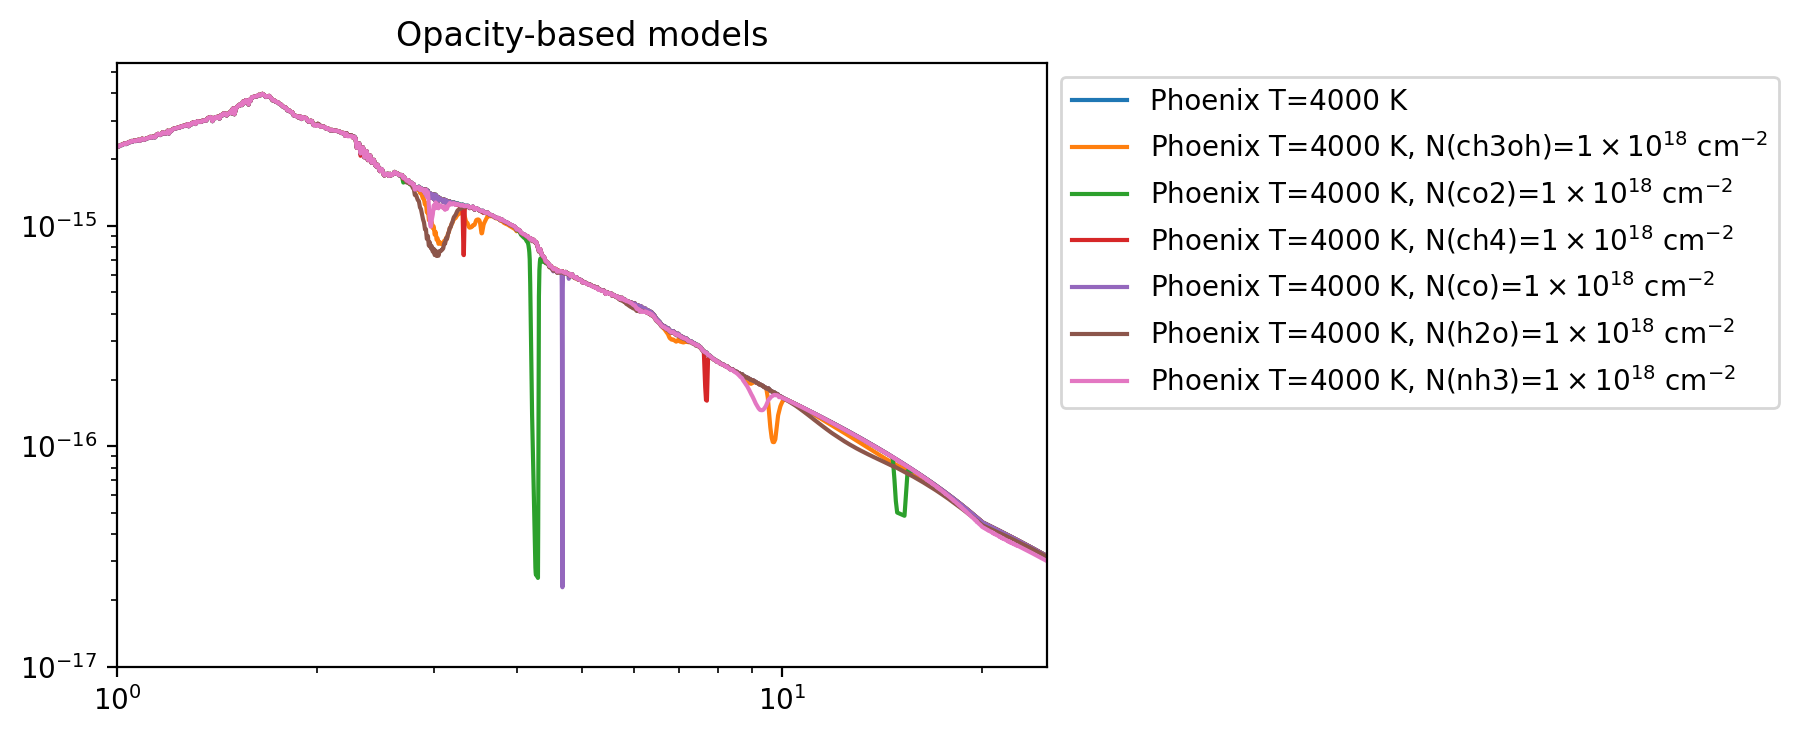

In [20]:
pl.figure(dpi=200)
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()), phx4000['fnu'], label="Phoenix T=4000 K")

for molecule, md in molecule_data.items():
    #print(molecule, md)
    consts = load_molecule(molecule)
    spec = absorbed_spectrum(1e18*u.cm**-2, consts, molecular_weight=md['molwt'])
    pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
              spec,
              label=f"Phoenix T=4000 K, N({molecule})=$1\\times10^{{18}}$ cm$^{{-2}}$")
pl.title("Opacity-based models")

pl.legend(bbox_to_anchor=[1.0, 1.0])
pl.ylim(1e-17, 5.5e-15)
pl.xlim(1.0, 25)

Text(0.5, 0, 'Wavelength [$\\mu$m]')

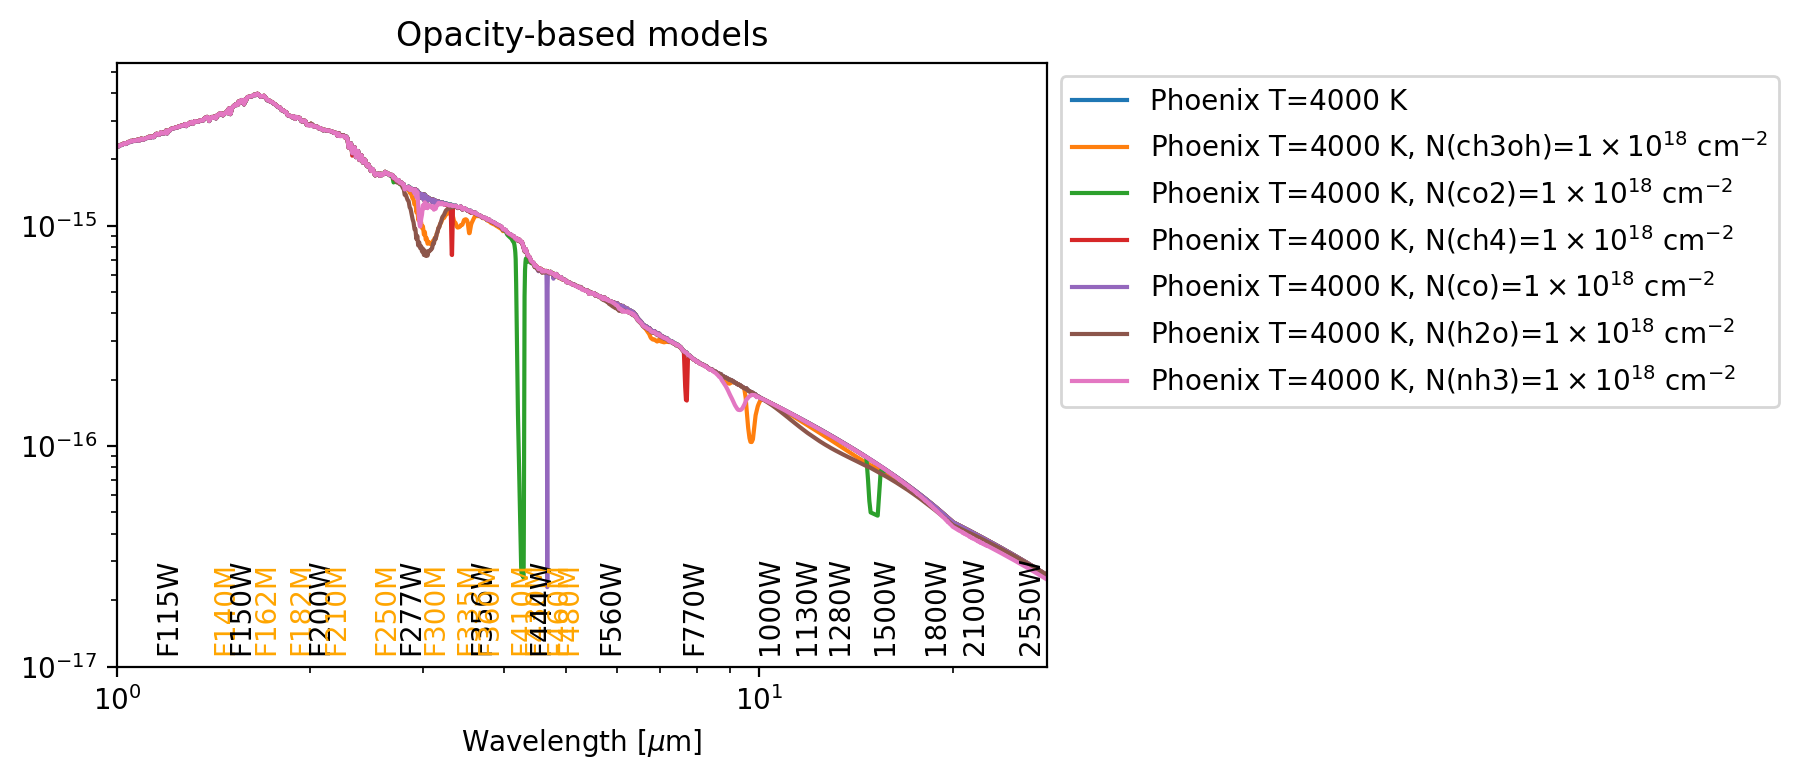

In [21]:
pl.figure(dpi=200)
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()), phx4000['fnu'], label="Phoenix T=4000 K")

for molecule, md in molecule_data.items():
    #print(molecule, md)
    consts = load_molecule(molecule)
    spec = absorbed_spectrum(1e18*u.cm**-2, consts, molecular_weight=md['molwt'])
    pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
              spec,
              label=f"Phoenix T=4000 K, N({molecule})=$1\\times10^{{18}}$ cm$^{{-2}}$")
pl.title("Opacity-based models")

for row in filter_data:
    if row['filterID'].endswith('W') and row['WavelengthEff'] > 10000:
        pl.text(u.Quantity(row['WavelengthEff'], u.AA).to(u.um).value,
                1.2e-17, row['filterID'][-5:], rotation=90)
    if row['filterID'].endswith('M') and row['WavelengthEff'] > 10000:
        pl.text(u.Quantity(row['WavelengthEff'], u.AA).to(u.um).value,
                1.2e-17, row['filterID'][-5:], rotation=90,
                color='orange')

pl.legend(bbox_to_anchor=[1.0, 1.0])
pl.ylim(1e-17, 5.5e-15)
pl.xlim(1.0, 28)
pl.xlabel("Wavelength [$\\mu$m]")


Text(0.5, 0, 'Wavelength [$\\mu$m]')

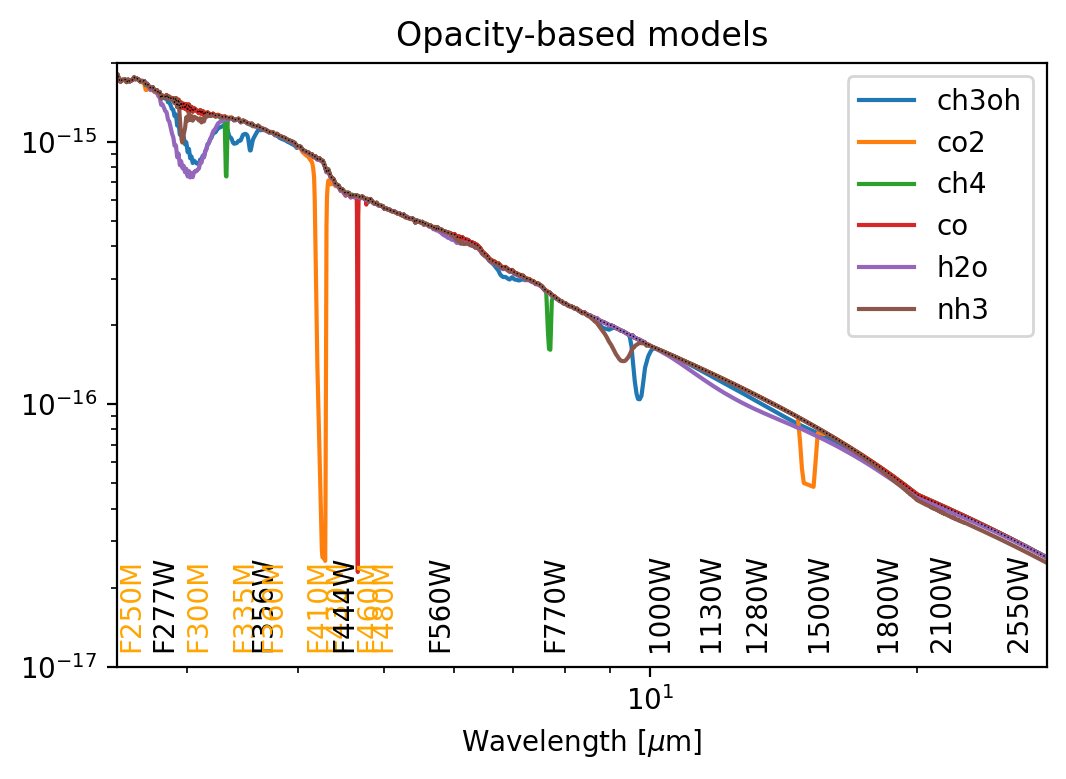

In [22]:
pl.figure(dpi=200)
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
          phx4000['fnu'], color='k', linestyle=':', zorder=20,
          linewidth=0.5)#, label="Phoenix T=4000 K")

for molecule, md in molecule_data.items():
    #print(molecule, md)
    consts = load_molecule(molecule)
    spec = absorbed_spectrum(1e18*u.cm**-2, consts, molecular_weight=md['molwt'])
    pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
              spec,
              label=f"{molecule}")
pl.title("Opacity-based models")

for row in filter_data:
    if row['filterID'].endswith('W') and row['WavelengthEff'] > 25000:
        pl.text(u.Quantity(row['WavelengthEff'], u.AA).to(u.um).value,
                1.2e-17, row['filterID'][-5:], rotation=90)
    if row['filterID'].endswith('M') and row['WavelengthEff'] > 25000:
        pl.text(u.Quantity(row['WavelengthEff'], u.AA).to(u.um).value,
                1.2e-17, row['filterID'][-5:], rotation=90,
                color='orange')

pl.legend(loc='upper right')#bbox_to_anchor=[1.0, 1.0])
pl.ylim(1e-17, 2e-15)
pl.xlim(2.5, 28)
pl.xlabel("Wavelength [$\\mu$m]")


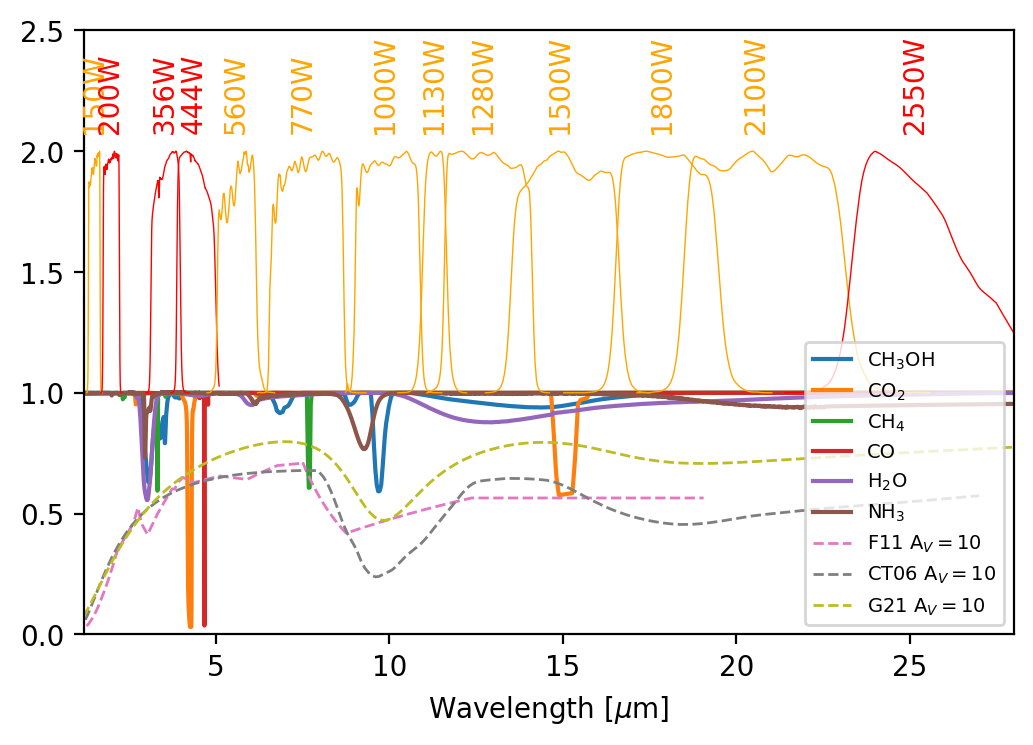

In [23]:
pl.figure(dpi=200)
# pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
#           phx4000['fnu'], color='k', linestyle=':', zorder=20,
#           linewidth=0.5)#, label="Phoenix T=4000 K")

xarr = u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral())
for molecule, md in molecule_data.items():
    #print(molecule, md)
    consts = load_molecule(molecule)
    spec = absorbed_spectrum(1e18*u.cm**-2, consts, molecular_weight=md['molwt'])
    pl.plot(xarr,
              spec / phx4000['fnu'],
              label=f"{label_map[molecule]}")
    
#slc = ((xarr > (u.Quantity(ext.x_range, u.um**-1).to(xarr.unit, u.spectral())).min()) &
#       (xarr < (u.Quantity(ext.x_range, u.um**-1).to(xarr.unit, u.spectral())).max()))
#ext_ = ext.extinguish(xarr[slc], Av=10)
#pl.plot(xarr[slc], ext_, label='A$_V=10$')
#pl.title("Opacity-based models")
for ext, extname in zip((F11_MWGC(), CT06_MWGC(), G21_MWAvg()),
                        ('F11', 'CT06', 'G21'),
                       ):
    slc = ((xarr > (u.Quantity(ext.x_range, u.um**-1).to(xarr.unit, u.spectral())).min()) &
           (xarr < (u.Quantity(ext.x_range, u.um**-1).to(xarr.unit, u.spectral())).max()))
    ext_ = ext.extinguish(xarr[slc], Av=10)
    pl.plot(xarr[slc], ext_, label=f'{extname} A$_V=10$', linestyle='--', linewidth=1)

GTO1182 = ['F115W', 'F200W', 'F356W', 'F444W']
GO2221 = ['F182M', 'F187N', 'F212N', 'F405N', 'F410M', 'F466N', 'F2550W']
proposed = ['F560W', 'F770W', 'F1000W', 'F1130W', 'F1280W', 'F1500W', 'F1800W', 'F2100W', 'F300M', 'F210M', 'F150W', 'F335M']
for row in filter_data:
    fname = row['filterID'].split('F')[-1]
    color = ('r' if f'F{fname}' in GTO1182+GO2221 else
             #'b' if f'F{fname}' in GO2221 else
             'orange' if 'F'+fname in proposed
             else 'k')
    if row['filterID'].endswith('W') and (row['WavelengthEff'] > 12000) and color!='k':
        pl.text(u.Quantity(row['WavelengthEff'], u.AA).to(u.um).value,
                2.1, fname, rotation=90, 
                horizontalalignment='center',
                color=color
               )
        trans = SvoFps.get_transmission_data(row['filterID'])
        pl.plot(trans['Wavelength'].quantity.to(u.um),
                trans['Transmission'].value/trans['Transmission'].value.max() + 1,
                linewidth=0.5,
                color=color)
    #if row['filterID'].endswith('M') and row['WavelengthEff'] > 25000:
    #    pl.text(u.Quantity(row['WavelengthEff'], u.AA).to(u.um).value,
    #            0.1, row['filterID'][-5:], rotation=90,
    #            color='orange')

pl.legend(loc='lower right', fontsize=7)#bbox_to_anchor=[1.0, 1.0])
pl.ylim(0, 2.5)
pl.xlim(1.2, 28)
pl.xlabel("Wavelength [$\\mu$m]")
pl.savefig("NIRCAMandMIRI_IceWindowsProposed.png", bbox_inches='tight');

In [24]:
pwd

'/blue/adamginsburg/adamginsburg/jwst/brick/notebooks'

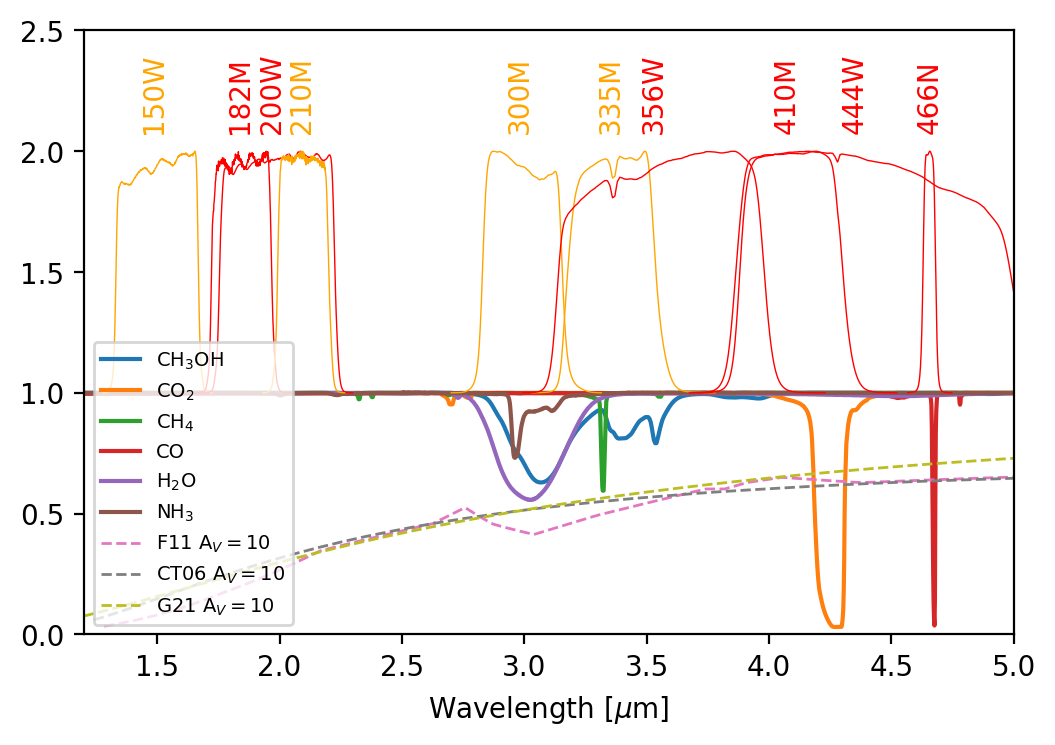

In [25]:
pl.figure(dpi=200)
# pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
#           phx4000['fnu'], color='k', linestyle=':', zorder=20,
#           linewidth=0.5)#, label="Phoenix T=4000 K")

xarr = u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral())
for molecule, md in molecule_data.items():
    #print(molecule, md)
    consts = load_molecule(molecule)
    spec = absorbed_spectrum(1e18*u.cm**-2, consts, molecular_weight=md['molwt'])
    pl.plot(xarr,
              spec / phx4000['fnu'],
              label=f"{label_map[molecule]}")
    
for ext, extname in zip((F11_MWGC(), CT06_MWGC(), G21_MWAvg()),
                        ('F11', 'CT06', 'G21'),
                       ):
    slc = ((xarr > (u.Quantity(ext.x_range, u.um**-1).to(xarr.unit, u.spectral())).min()) &
           (xarr < (u.Quantity(ext.x_range, u.um**-1).to(xarr.unit, u.spectral())).max()))
    ext_ = ext.extinguish(xarr[slc], Av=10)
    pl.plot(xarr[slc], ext_, label=f'{extname} A$_V=10$', linestyle='--', linewidth=1)
    #pl.title("Opacity-based models")

GTO1182 = ['F115W', 'F200W', 'F356W', 'F444W']
GO2221 = ['F182M', 'F187N', 'F212N', 'F405N', 'F410M', 'F466N', 'F2550W']
toplot = ['F300M', 'F210M', 'F182M', 'F410M', 'F466N', 'F150W', 'F335M']
for row in filter_data:
    fname = row['filterID'].split('F')[-1]
    color = ('r' if f'F{fname}' in GTO1182+GO2221 else
             #'b' if f'F{fname}' in GO2221 else
             'orange' if 'F'+fname in proposed
             else 'k')
    if (color!='k') and ((row['filterID'].endswith('W') or 'F'+fname in toplot)
                         and (row['WavelengthEff'] > 12000) and (row['WavelengthEff'] < 50000)):
        
        pl.text(u.Quantity(row['WavelengthEff'], u.AA).to(u.um).value,
                2.1, fname, rotation=90, 
                horizontalalignment='center',
                color=color
               )
        trans = SvoFps.get_transmission_data(row['filterID'])
        pl.plot(trans['Wavelength'].quantity.to(u.um),
                trans['Transmission'].value/trans['Transmission'].value.max() + 1,
                linewidth=0.5, color=color)
    #if row['filterID'].endswith('M') and row['WavelengthEff'] > 25000:
    #    pl.text(u.Quantity(row['WavelengthEff'], u.AA).to(u.um).value,
    #            0.1, row['filterID'][-5:], rotation=90,
    #            color='orange')

pl.legend(loc='lower left', fontsize=7)#bbox_to_anchor=[1.0, 1.0])
pl.ylim(0, 2.5)
pl.xlim(1.2, 5)
pl.xlabel("Wavelength [$\\mu$m]");
pl.savefig("NIRCAM_IceWindowsProposed.png", bbox_inches='tight');

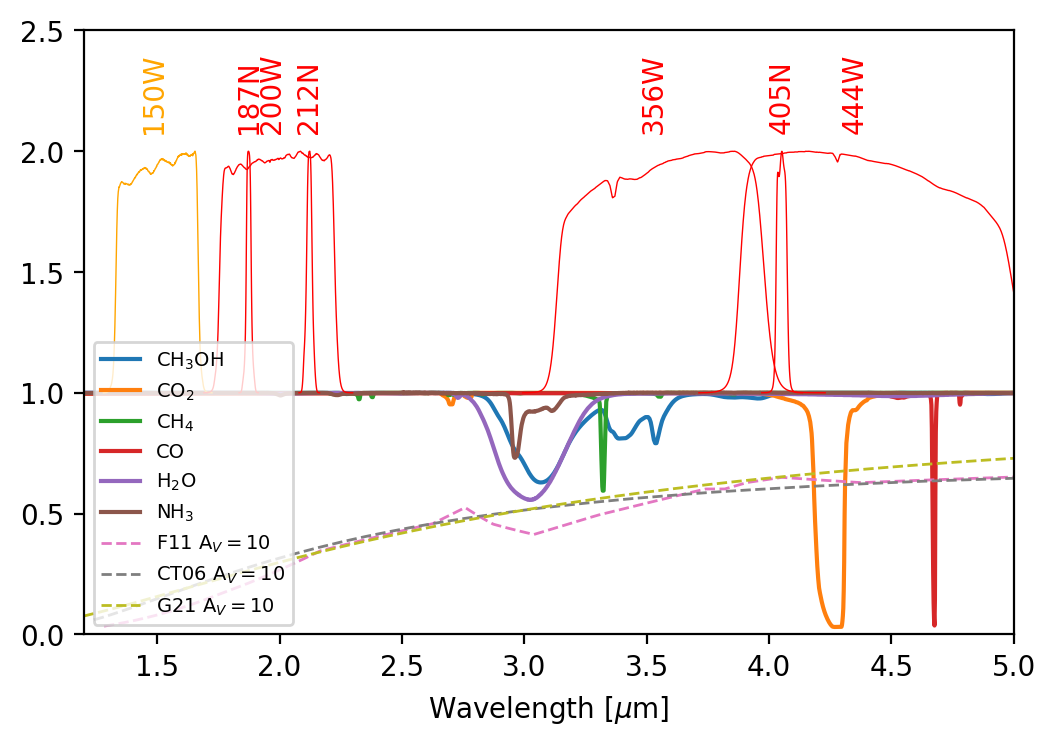

In [26]:
pl.figure(dpi=200)
# pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
#           phx4000['fnu'], color='k', linestyle=':', zorder=20,
#           linewidth=0.5)#, label="Phoenix T=4000 K")

xarr = u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral())
for molecule, md in molecule_data.items():
    #print(molecule, md)
    consts = load_molecule(molecule)
    spec = absorbed_spectrum(1e18*u.cm**-2, consts, molecular_weight=md['molwt'])
    pl.plot(xarr,
              spec / phx4000['fnu'],
              label=f"{label_map[molecule]}")
    
for ext, extname in zip((F11_MWGC(), CT06_MWGC(), G21_MWAvg()),
                        ('F11', 'CT06', 'G21'),
                       ):
    slc = ((xarr > (u.Quantity(ext.x_range, u.um**-1).to(xarr.unit, u.spectral())).min()) &
           (xarr < (u.Quantity(ext.x_range, u.um**-1).to(xarr.unit, u.spectral())).max()))
    ext_ = ext.extinguish(xarr[slc], Av=10)
    pl.plot(xarr[slc], ext_, label=f'{extname} A$_V=10$', linestyle='--', linewidth=1)
    #pl.title("Opacity-based models")

GTO1182 = ['F115W', 'F200W', 'F356W', 'F444W']
GO2221 = ['F182M', 'F187N', 'F212N', 'F405N', 'F410M', 'F466N', 'F2550W']
toplot = ['F300M', 'F210M', 'F182M', 'F410M', 'F466N', 'F150W', 'F335M', 'F480M']
toplot = ['F187N', 'F212N', 'F405N', 'F480M']
for row in filter_data:
    fname = row['filterID'].split('F')[-1]
    color = ('r' if f'F{fname}' in GTO1182+GO2221 else
             #'b' if f'F{fname}' in GO2221 else
             'orange' if 'F'+fname in proposed
             else 'k')
    if (color!='k') and ((row['filterID'].endswith('W') or 'F'+fname in toplot)
                         and (row['WavelengthEff'] > 12000) and (row['WavelengthEff'] < 50000)):
        
        pl.text(u.Quantity(row['WavelengthEff'], u.AA).to(u.um).value,
                2.1, fname, rotation=90, 
                horizontalalignment='center',
                color=color
               )
        trans = SvoFps.get_transmission_data(row['filterID'])
        pl.plot(trans['Wavelength'].quantity.to(u.um),
                trans['Transmission'].value/trans['Transmission'].value.max() + 1,
                linewidth=0.5, color=color)
    #if row['filterID'].endswith('M') and row['WavelengthEff'] > 25000:
    #    pl.text(u.Quantity(row['WavelengthEff'], u.AA).to(u.um).value,
    #            0.1, row['filterID'][-5:], rotation=90,
    #            color='orange')

pl.legend(loc='lower left', fontsize=7)#bbox_to_anchor=[1.0, 1.0])
pl.ylim(0, 2.5)
pl.xlim(1.2, 5)
pl.xlabel("Wavelength [$\\mu$m]");
#pl.savefig("NIRCAM_IceWindowsProposed.png", bbox_inches='tight');

In [27]:
prop_cycle = pl.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

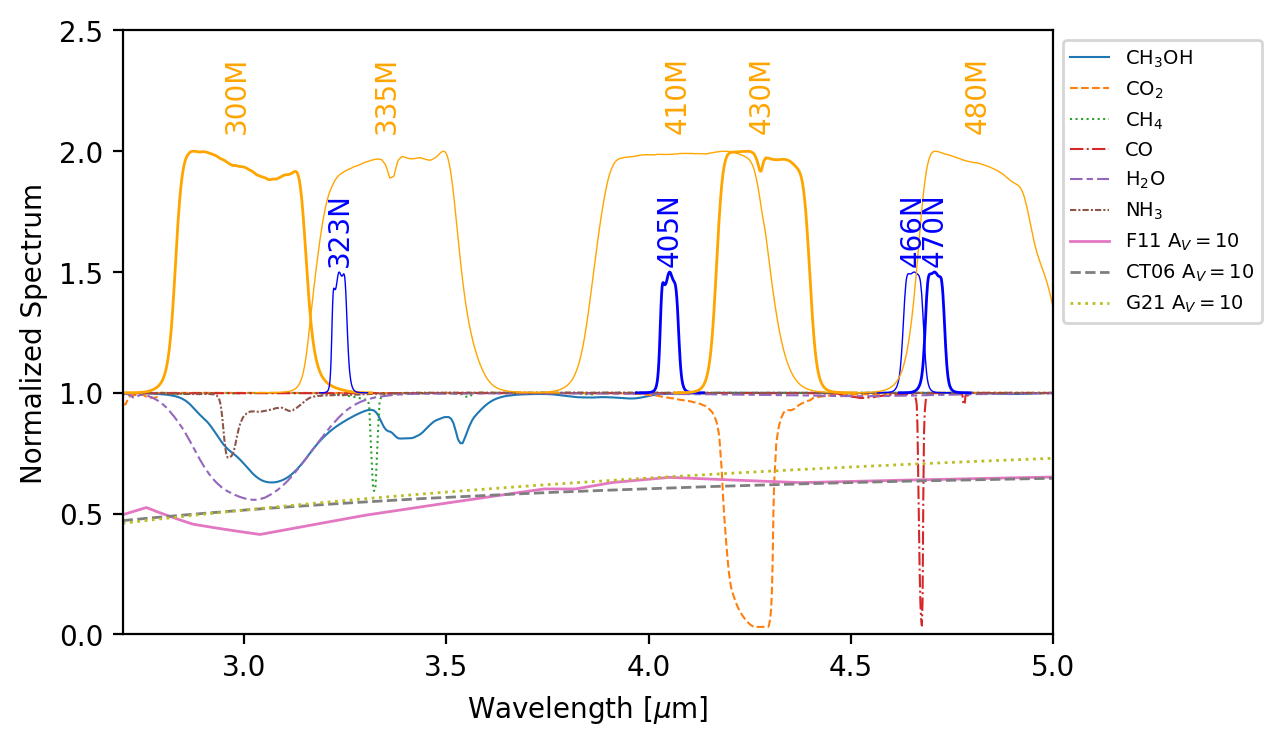

In [28]:
pl.figure(dpi=200)
# pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
#           phx4000['fnu'], color='k', linestyle=':', zorder=20,
#           linewidth=0.5)#, label="Phoenix T=4000 K")

xarr = u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral())
for (molecule, md), (ls, lw) in zip(molecule_data.items(), zip(('-', '--', ':', '-.', (0, (6,2,3,2)), (0, (3,1,1,1))), (0.75,)*6)):
    #print(molecule, md)
    consts = load_molecule(molecule)
    spec = absorbed_spectrum(1e18*u.cm**-2, consts, molecular_weight=md['molwt'])
    pl.plot(xarr,
            spec / phx4000['fnu'],
            label=f"{label_map[molecule]}",
            linewidth=lw,
            linestyle=ls,
           )
    
for ext, extname, linestyle in zip((F11_MWGC(), CT06_MWGC(), G21_MWAvg()),
                        ('F11', 'CT06', 'G21'),
                        ('-', '--', ':'),
                       ):
    slc = ((xarr > (u.Quantity(ext.x_range, u.um**-1).to(xarr.unit, u.spectral())).min()) &
           (xarr < (u.Quantity(ext.x_range, u.um**-1).to(xarr.unit, u.spectral())).max()))
    ext_ = ext.extinguish(xarr[slc], Av=10)
    pl.plot(xarr[slc], ext_, label=f'{extname} A$_V=10$', linestyle=linestyle, linewidth=1)
    #pl.title("Opacity-based models")

toplot = ['F323N', 'F300M', 'F335M', 'F410M', 'F405N', 'F430M', 'F466N', 'F470N', 'F480M']
for ii, row in enumerate(filter_data):
    fname = row['filterID'].split('F')[-1]
    color = ('r' if fname.endswith('W') else
             'orange' if fname.endswith('M') else 
             'blue' if fname.endswith('N')
             else 'k')
    if (color!='k') and ('F'+fname in toplot
                         and (row['WavelengthEff'] > 12000) and (row['WavelengthEff'] < 50000)):
        
        vertfac = (0.5 if fname.endswith('N') else 1)
        pl.text(u.Quantity(row['WavelengthEff'], u.AA).to(u.um).value,
                1+1.1 * vertfac, fname, rotation=90, 
                horizontalalignment='center',
                color=color,
               )
        trans = SvoFps.get_transmission_data(row['filterID'])
        pl.plot(trans['Wavelength'].quantity.to(u.um),
                trans['Transmission'].value/trans['Transmission'].value.max() * vertfac + 1,
                linewidth=0.5 if ii % 2 == 0 else 1,
                color=color)
    #if row['filterID'].endswith('M') and row['WavelengthEff'] > 25000:
    #    pl.text(u.Quantity(row['WavelengthEff'], u.AA).to(u.um).value,
    #            0.1, row['filterID'][-5:], rotation=90,
    #            color='orange')

pl.legend(loc='lower left', fontsize=7, bbox_to_anchor=[1.0, 0.50])
pl.ylim(0, 2.5)
pl.xlim(2.7, 5)
pl.xlabel("Wavelength [$\\mu$m]");
pl.ylabel("Normalized Spectrum")
pl.savefig("/orange/adamginsburg/jwst/brick/paper_co/figures/NIRCAM_IceAffectedFilters.png", bbox_inches='tight', dpi=200);
pl.savefig("/orange/adamginsburg/jwst/brick/paper_co/figures/NIRCAM_IceAffectedFilters.pdf", bbox_inches='tight', dpi=200);

### Spitzer

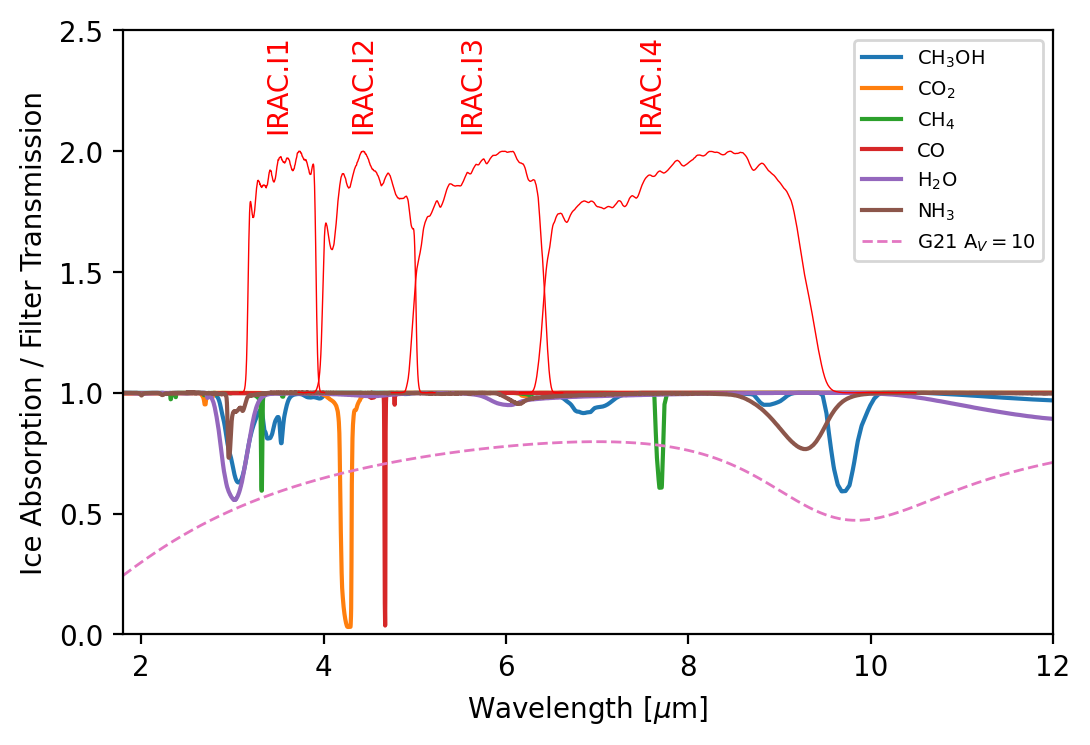

In [29]:
pl.figure(dpi=200)
# pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
#           phx4000['fnu'], color='k', linestyle=':', zorder=20,
#           linewidth=0.5)#, label="Phoenix T=4000 K")

xarr = u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral())
for molecule, md in molecule_data.items():
    #print(molecule, md)
    consts = load_molecule(molecule)
    spec = absorbed_spectrum(1e18*u.cm**-2, consts, molecular_weight=md['molwt'])
    pl.plot(xarr,
              spec / phx4000['fnu'],
              label=f"{label_map[molecule]}")
    
for ext, extname in zip((G21_MWAvg(),),
                        ('G21', ),
                       ):
#for ext, extname in zip((F11_MWGC(), CT06_MWGC(), G21_MWAvg()),
#                        ('F11', 'CT06', 'G21'),
#                       ):
    slc = ((xarr > (u.Quantity(ext.x_range, u.um**-1).to(xarr.unit, u.spectral())).min()) &
           (xarr < (u.Quantity(ext.x_range, u.um**-1).to(xarr.unit, u.spectral())).max()))
    ext_ = ext.extinguish(xarr[slc], Av=10)
    pl.plot(xarr[slc], ext_, label=f'{extname} A$_V=10$', linestyle='--', linewidth=1)
    #pl.title("Opacity-based models")

toplot = ['IRAC.I1', 'IRAC.I2', 'IRAC.I3', 'IRAC.I4',]# 'MIPS.24mu']
for row in filter_data_spitzer:
    fname = row['filterID']
    if fname.split("/")[-1] in toplot:
        color = 'r'
        pl.text(u.Quantity(row['WavelengthEff'], u.AA).to(u.um).value,
                2.1, fname.split("/")[-1], rotation=90, 
                horizontalalignment='center',
                color=color
               )
        trans = SvoFps.get_transmission_data(row['filterID'])
        pl.plot(trans['Wavelength'].quantity.to(u.um),
                trans['Transmission'].value/trans['Transmission'].value.max() + 1,
                linewidth=0.5, color=color)
        #if row['filterID'].endswith('M') and row['WavelengthEff'] > 25000:
        #    pl.text(u.Quantity(row['WavelengthEff'], u.AA).to(u.um).value,
        #            0.1, row['filterID'][-5:], rotation=90,
        #            color='orange')

pl.legend(loc='upper right', fontsize=7)#bbox_to_anchor=[1.0, 1.0])
pl.ylim(0, 2.5)
pl.xlim(1.8, 12)
pl.ylabel("Ice Absorption / Filter Transmission")
pl.xlabel("Wavelength [$\\mu$m]");
pl.savefig("Spitzer_IceWindows.png", bbox_inches='tight');
pl.savefig("Spitzer_IceWindows.pdf", bbox_inches='tight');

In [30]:
filter_data[:2]

FilterProfileService,filterID,WavelengthUnit,WavelengthUCD,PhotSystem,DetectorType,Band,Instrument,Facility,ProfileReference,CalibrationReference,Description,Comments,WavelengthRef,WavelengthMean,WavelengthEff,WavelengthMin,WavelengthMax,WidthEff,WavelengthCen,WavelengthPivot,WavelengthPeak,WavelengthPhot,FWHM,Fsun,PhotCalID,MagSys,ZeroPoint,ZeroPointUnit,Mag0,ZeroPointType,AsinhSoft,TrasmissionCurve
,,,,,,,,,,,,,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,erg / (A s cm2),,,Jy,,,,,
object,object,object,object,object,object,object,object,object,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,object,float64,object,float64,object
ivo://svo/fps,JWST/NIRCam.F070W,Angstrom,em.wl,NIRCam,1,,NIRCam,JWST,https://jwst-docs.stsci.edu/display/JTI/NIRCam+Filters,,NIRCam F070W filter,"includes NIRCam optics, DBS, QE and JWST Optical Telescope Element",7039.1194650654,7088.3009369996,6988.4272768359,6048.1970523246,7927.0738659178,1212.8399166581,7099.1873443748,7039.1194650654,7691.5,7022.060805287,1430.8105961315,140.01772043307,JWST/NIRCam.F070W/Vega,Vega,2768.4045696982,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.php?ID=JWST/NIRCam.F070W
ivo://svo/fps,JWST/NIRCam.F090W,Angstrom,em.wl,NIRCam,1,,NIRCam,JWST,https://jwst-docs.stsci.edu/display/JTI/NIRCam+Filters,,NIRCam F090W filter,"includes NIRCam optics, DBS, QE and JWST Optical Telescope Element",9021.5288283376,9083.3952700859,8984.9812166695,7881.875216583,10243.081731613,1772.7418859059,9007.2449821231,9021.5288283376,9905.5,9026.3413455784,2088.0551132236,89.25825936013,JWST/NIRCam.F090W/Vega,Vega,2244.9507457345,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.php?ID=JWST/NIRCam.F090W


In [31]:
#GTO1182 = ['F115W', 'F200W', 'F356W', 'F444W']
#GO2221 = ['F182M', 'F187N', 'F212N', 'F405N', 'F410M', 'F466N', 'F2550W']
cmds = [# too boring (('JWST/NIRCam.F182M', 'JWST/NIRCam.F212N'),
        # too boring  ('JWST/NIRCam.F115W', 'JWST/NIRCam.F200W')),
        (('JWST/NIRCam.F356W', 'JWST/NIRCam.F444W'),
         ('JWST/NIRCam.F410M', 'JWST/NIRCam.F466N')),
         #('JWST/NIRCam.F115W', 'JWST/NIRCam.F200W')),
        (('JWST/NIRCam.F150W', 'JWST/NIRCam.F210M'),
         ('JWST/NIRCam.F300M', 'JWST/NIRCam.F335M')),
        #(('JWST/NIRCam.F300M', 'JWST/NIRCam.F356W'),
        # ('JWST/NIRCam.F466N', 'JWST/NIRCam.F444W')),
        (('JWST/MIRI.F560W', 'JWST/MIRI.F770W'),
         ('JWST/MIRI.F1000W', 'JWST/MIRI.F1130W')),
        (('JWST/MIRI.F1280W', 'JWST/MIRI.F1500W'),
         ('JWST/MIRI.F1800W', 'JWST/MIRI.F2100W')),
       ]

In [32]:
import matplotlib

In [33]:
temperatures = (2000, 3000, 4000, 5000, 7000, 10000, 12000, 15000, 25000, 39000)

tmods = {temperature: atmo_model(temperature)
         for temperature in temperatures}

## Color-color diagrams

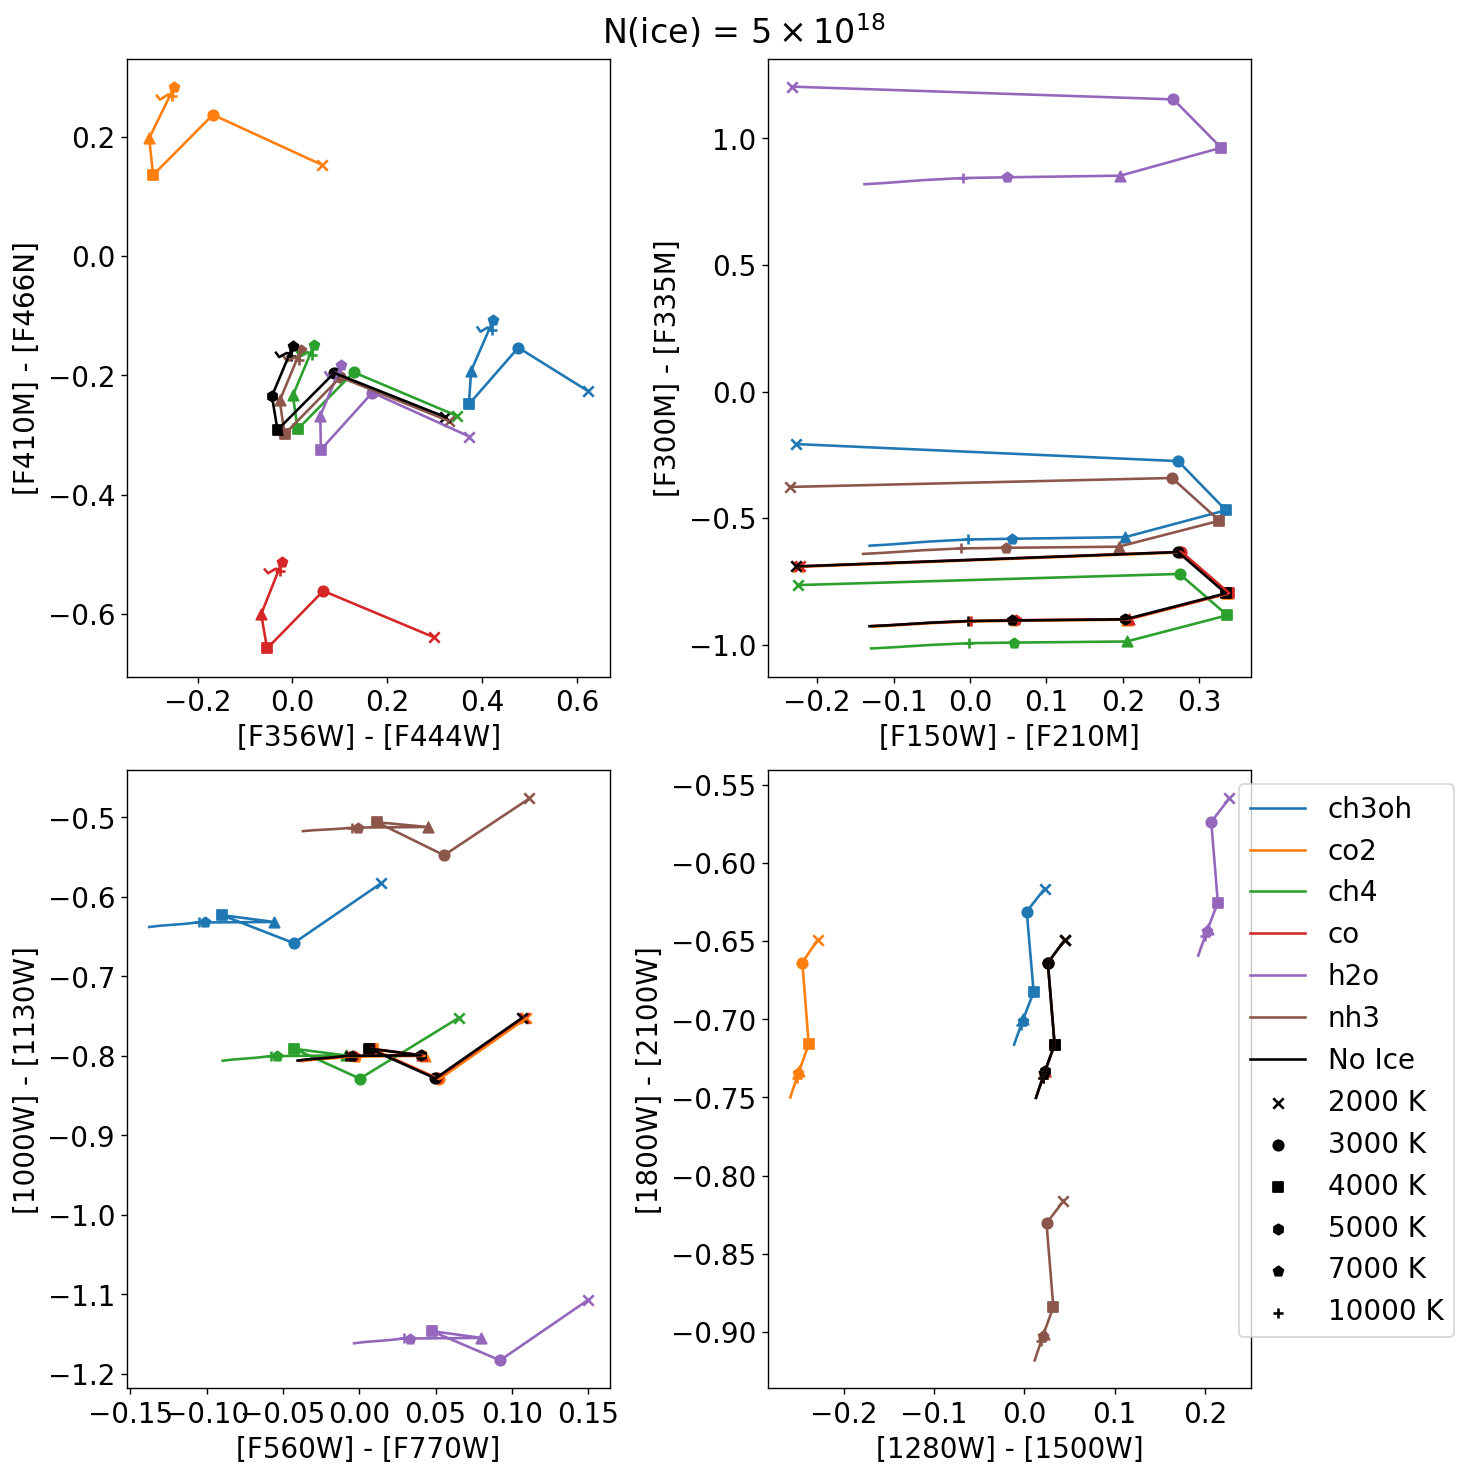

In [34]:
pl.figure(figsize=(12, 12), dpi=125)
#xarr = u.Quantity(phx4000['nu'],u.Hz).to(u.um, u.spectral())


with matplotlib.rc_context({'font.size': 16}):
    for ii, (cmd_x, cmd_y) in enumerate(cmds):
        ax = pl.subplot(2, 2, ii+1)
        ax.set_xlabel(f'[{cmd_x[0][-5:]}] - [{cmd_x[1][-5:]}]')
        ax.set_ylabel(f'[{cmd_y[0][-5:]}] - [{cmd_y[1][-5:]}]')

        
        for molecule, moldata in molecule_data.items():
            consts = load_molecule(molecule)
            xdata = []
            ydata = []
            for temperature in temperatures:
                xarr = tmods[temperature]['nu'].quantity.to(u.um, u.spectral())
                spec = absorbed_spectrum(5e18*u.cm**-2, consts, molecular_weight=moldata['molwt'],
                                          spectrum=tmods[temperature]['fnu'].quantity,
                                          xarr=xarr,
                                         )

                flxd = fluxes_in_filters(xarr, spec)
                mags_x = (-2.5*np.log10(flxd[cmd_x[0]] / u.Quantity(jfilts.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
                          -2.5*np.log10(flxd[cmd_x[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
                mags_y = (-2.5*np.log10(flxd[cmd_y[0]] / u.Quantity(jfilts.loc[cmd_y[0]]['ZeroPoint'], u.Jy)),
                          -2.5*np.log10(flxd[cmd_y[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
                xdata.append(mags_x[0]-mags_x[1])
                ydata.append(mags_y[0]-mags_y[1])
            #ax.scatter(xdata, ydata, color=pl.cm.jet(temperatures), label=molecule)
            L, = ax.plot(xdata, ydata, label=molecule)
            #print(xdata, ydata)
            for marker, temperature, xx, yy in zip('xos^p+', temperatures, xdata, ydata):
                ax.scatter(xx, yy, marker=marker, color=L.get_color())
                #print(xx, yy)

        xdata = []
        ydata = []
        for temperature in temperatures:
            xarr = tmods[temperature]['nu'].quantity.to(u.um, u.spectral())
            flxd = fluxes_in_filters(xarr, tmods[temperature]['fnu'].quantity)
            mags_x = (-2.5*np.log10(flxd[cmd_x[0]] / u.Quantity(jfilts.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
                      -2.5*np.log10(flxd[cmd_x[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            mags_y = (-2.5*np.log10(flxd[cmd_y[0]] / u.Quantity(jfilts.loc[cmd_y[0]]['ZeroPoint'], u.Jy)),
                      -2.5*np.log10(flxd[cmd_y[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            xdata.append(mags_x[0]-mags_x[1])
            ydata.append(mags_y[0]-mags_y[1])
        ax.plot(xdata, ydata, label='No Ice', color='k')
        for marker, temperature, xx, yy in zip('xoshp+', temperatures, xdata, ydata):
            ax.scatter(xx, yy, marker=marker, color='k', label=f'{temperature} K')
        

    pl.legend(loc='upper right', bbox_to_anchor=[1.45,1.0])
    pl.suptitle("N(ice) = $5\\times10^{18}$")
pl.tight_layout()

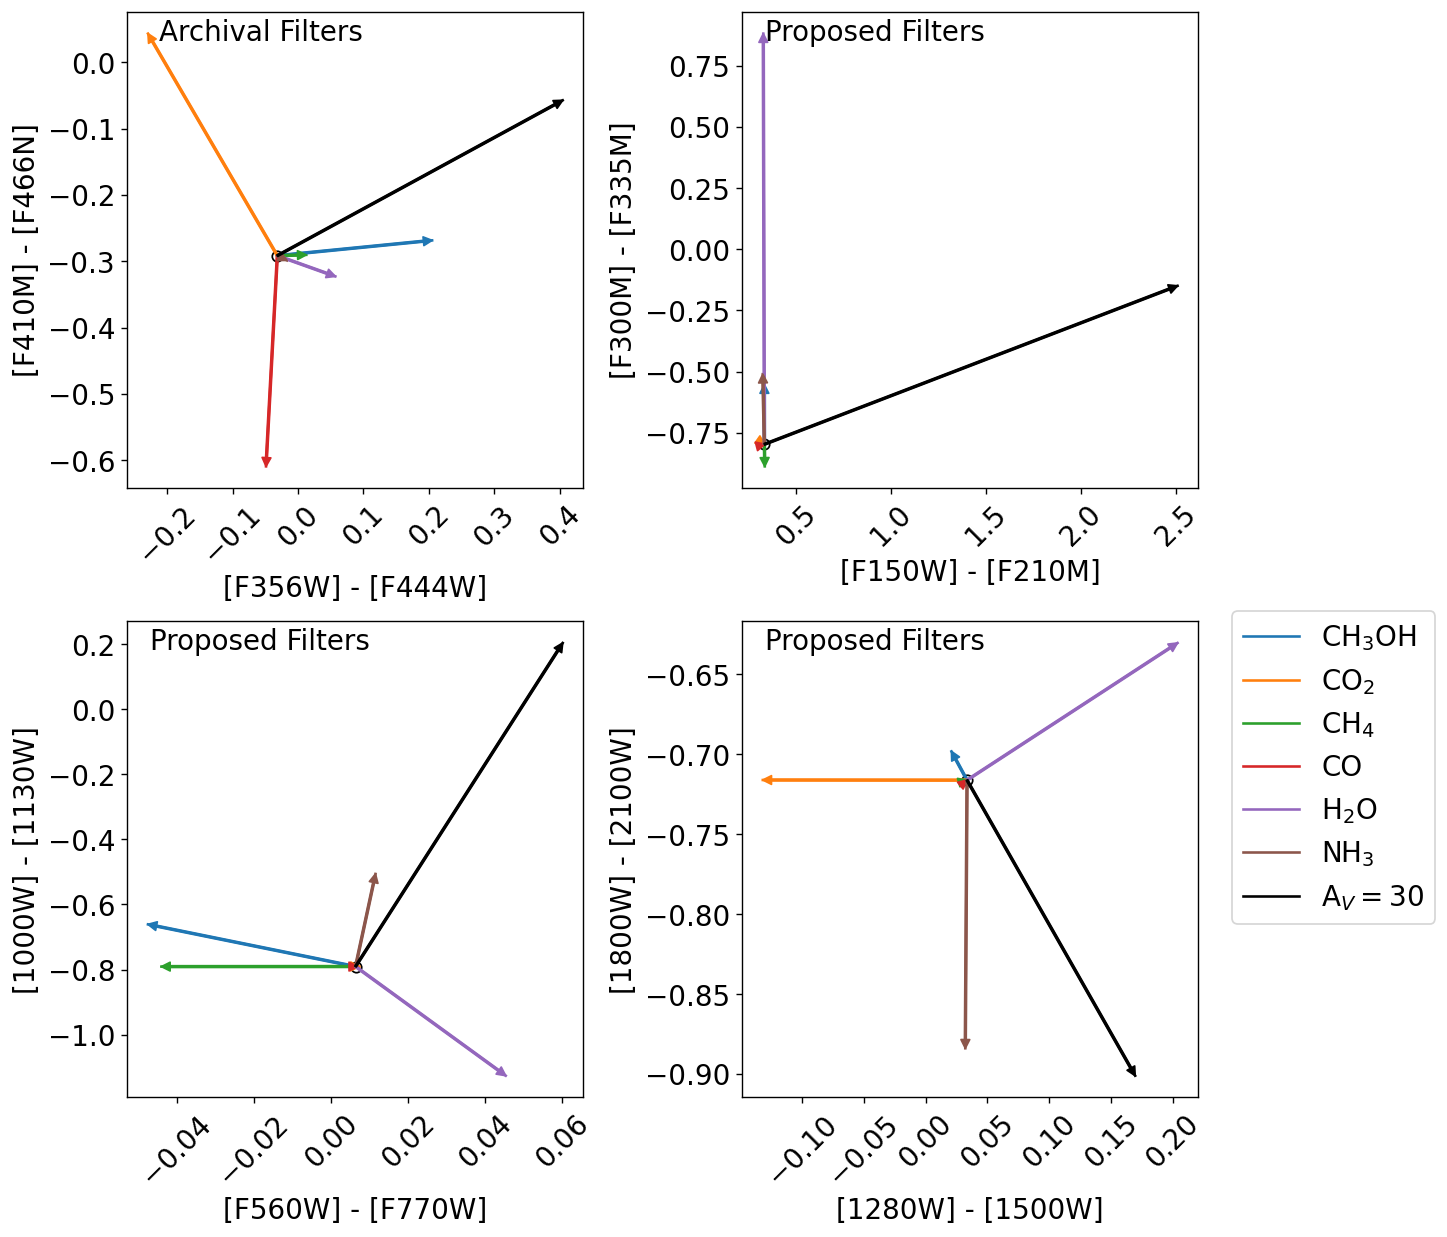

In [35]:
pl.figure(figsize=(12, 10), dpi=125)
#xarr = u.Quantity(phx4000['nu'],u.Hz).to(u.um, u.spectral())

temperature = 4000

with matplotlib.rc_context({'font.size': 16}):
    for ii, (cmd_x, cmd_y) in enumerate(cmds):
        ax = pl.subplot(2, 2, ii+1)
        ax.set_xlabel(f'[{cmd_x[0][-5:]}] - [{cmd_x[1][-5:]}]')
        ax.set_ylabel(f'[{cmd_y[0][-5:]}] - [{cmd_y[1][-5:]}]')

        
        xarr_ref = tmods[temperature]['nu'].quantity.to(u.um, u.spectral())
        flxd_ref = fluxes_in_filters(xarr, tmods[temperature]['fnu'].quantity)
        xs,ys,us,vs,cs = [],[],[],[],[]
        for (molecule, moldata), color in zip(molecule_data.items(),
                                            pl.rcParams['axes.prop_cycle'].by_key()['color']):
            consts = load_molecule(molecule)
            xdata = []
            ydata = []
            xarr = tmods[temperature]['nu'].quantity.to(u.um, u.spectral())
            spec = absorbed_spectrum(5e18*u.cm**-2, consts, molecular_weight=md['molwt'],
                                      spectrum=tmods[temperature]['fnu'].quantity,
                                      xarr=xarr,
                                     )

            flxd = fluxes_in_filters(xarr, spec)
            mags_x_star = (-2.5*np.log10(flxd_ref[cmd_x[0]] / u.Quantity(jfilts.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
                           -2.5*np.log10(flxd_ref[cmd_x[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            mags_y_star = (-2.5*np.log10(flxd_ref[cmd_y[0]] / u.Quantity(jfilts.loc[cmd_y[0]]['ZeroPoint'], u.Jy)),
                           -2.5*np.log10(flxd_ref[cmd_y[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            xdata.append(mags_x_star[0]-mags_x_star[1])
            ydata.append(mags_y_star[0]-mags_y_star[1])
            mags_x = (-2.5*np.log10(flxd[cmd_x[0]] / u.Quantity(jfilts.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
                      -2.5*np.log10(flxd[cmd_x[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            mags_y = (-2.5*np.log10(flxd[cmd_y[0]] / u.Quantity(jfilts.loc[cmd_y[0]]['ZeroPoint'], u.Jy)),
                      -2.5*np.log10(flxd[cmd_y[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            xdata.append(mags_x[0]-mags_x[1])
            ydata.append(mags_y[0]-mags_y[1])
            #ax.scatter(xdata, ydata, color=pl.cm.jet(temperatures), label=molecule)
            L, = ax.plot(xdata, ydata, label=label_map[molecule])
            arrow_start = xdata[0], ydata[0]
            arrow_end = xdata[1], ydata[1]
            ax.annotate('', arrow_end, arrow_start,
                        arrowprops=dict(width=1, headwidth=5, headlength=5,
                        edgecolor=L.get_color(),
                        facecolor=L.get_color(),
                                       ),
                        color=L.get_color(),
                       )
            #L.set_visible(False) # hide these, but force the ax lims?
            #dx = pl.xlim()[1] - pl.xlim()[0]
            #ax.arrow(xdata[0], ydata[0], xdata[1]-xdata[0], ydata[1]-ydata[0])#, width=dx/30)
            xs.append(xdata[0])
            ys.append(ydata[0])
            us.append(xdata[1]-xdata[0])
            vs.append(ydata[1]-ydata[0])
            cs.append(color)
            #ax.set_xticklabels(rotation=45) # https://stackoverflow.com/questions/10998621/rotate-axis-text-in-python-matplotlib
            ax.tick_params(axis='x', labelrotation=45)
            #print(xdata, ydata)
            #for marker, temperature, xx, yy in zip('xos^p+', temperatures, xdata, ydata):
            #    ax.scatter(xx, yy, marker=marker, color=L.get_color())
            #print(xx, yy)
        slc = ((xarr > (u.Quantity(ext.x_range, u.um**-1).to(xarr.unit, u.spectral())).min()) &
               (xarr < (u.Quantity(ext.x_range, u.um**-1).to(xarr.unit, u.spectral())).max()))
        attenuation = 10**(-ext(xarr[slc]) * av / 2.5)
        extspec = spec[slc] * attenuation
        flxd_ext = fluxes_in_filters(xarr[slc], extspec)
        xdata = [mags_x_star[0]-mags_x_star[1]]
        ydata = [mags_y_star[0]-mags_y_star[1]]
        ax.plot(xdata, ydata, marker='o', markerfacecolor='w', markeredgecolor='k', zorder=-10)
        mags_x = (-2.5*np.log10(flxd_ext[cmd_x[0]] / u.Quantity(jfilts.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
                  -2.5*np.log10(flxd_ext[cmd_x[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
        mags_y = (-2.5*np.log10(flxd_ext[cmd_y[0]] / u.Quantity(jfilts.loc[cmd_y[0]]['ZeroPoint'], u.Jy)),
                  -2.5*np.log10(flxd_ext[cmd_y[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
        xdata.append(mags_x[0]-mags_x[1])
        ydata.append(mags_y[0]-mags_y[1])
        L, = ax.plot(xdata, ydata, label=f'A$_V={av}$', color='k')
        arrow_start = xdata[0], ydata[0]
        arrow_end = xdata[1], ydata[1]
        ax.annotate('', arrow_end, arrow_start,
                    arrowprops=dict(width=1, headwidth=5, headlength=5,
                    edgecolor=L.get_color(),
                    facecolor=L.get_color(),
                                   ),
                    color=L.get_color(),
                   )
        # can't label with quiver.
        # ax.quiver(xs, ys, us, vs, np.arange(len(xs)), angles='xy', cmap='rainbow',
        #           scale_units='xy',
        #           scale=1,
        #          )
        # https://stackoverflow.com/questions/45148539/project-variables-in-pca-plot-in-python
        #dx = pl.xlim()[1] - pl.xlim()[0]
        #for arrow in ax.patches:
        #    arrow.set_data(width=dx/50)
        
        if ii == 0:
            ax.text(0.07, 0.94, "Archival Filters", transform=ax.transAxes)
        else:
            ax.text(0.05, 0.94, "Proposed Filters", transform=ax.transAxes)


    pl.legend(loc='upper right', bbox_to_anchor=[1.55,1.05])
    #pl.suptitle("N(ice) = $5\\times10^{18}$ cm$^{-2}$")
pl.tight_layout()
pl.savefig("IceColors_NIRCAM_MIRI.png", bbox_inches='tight')

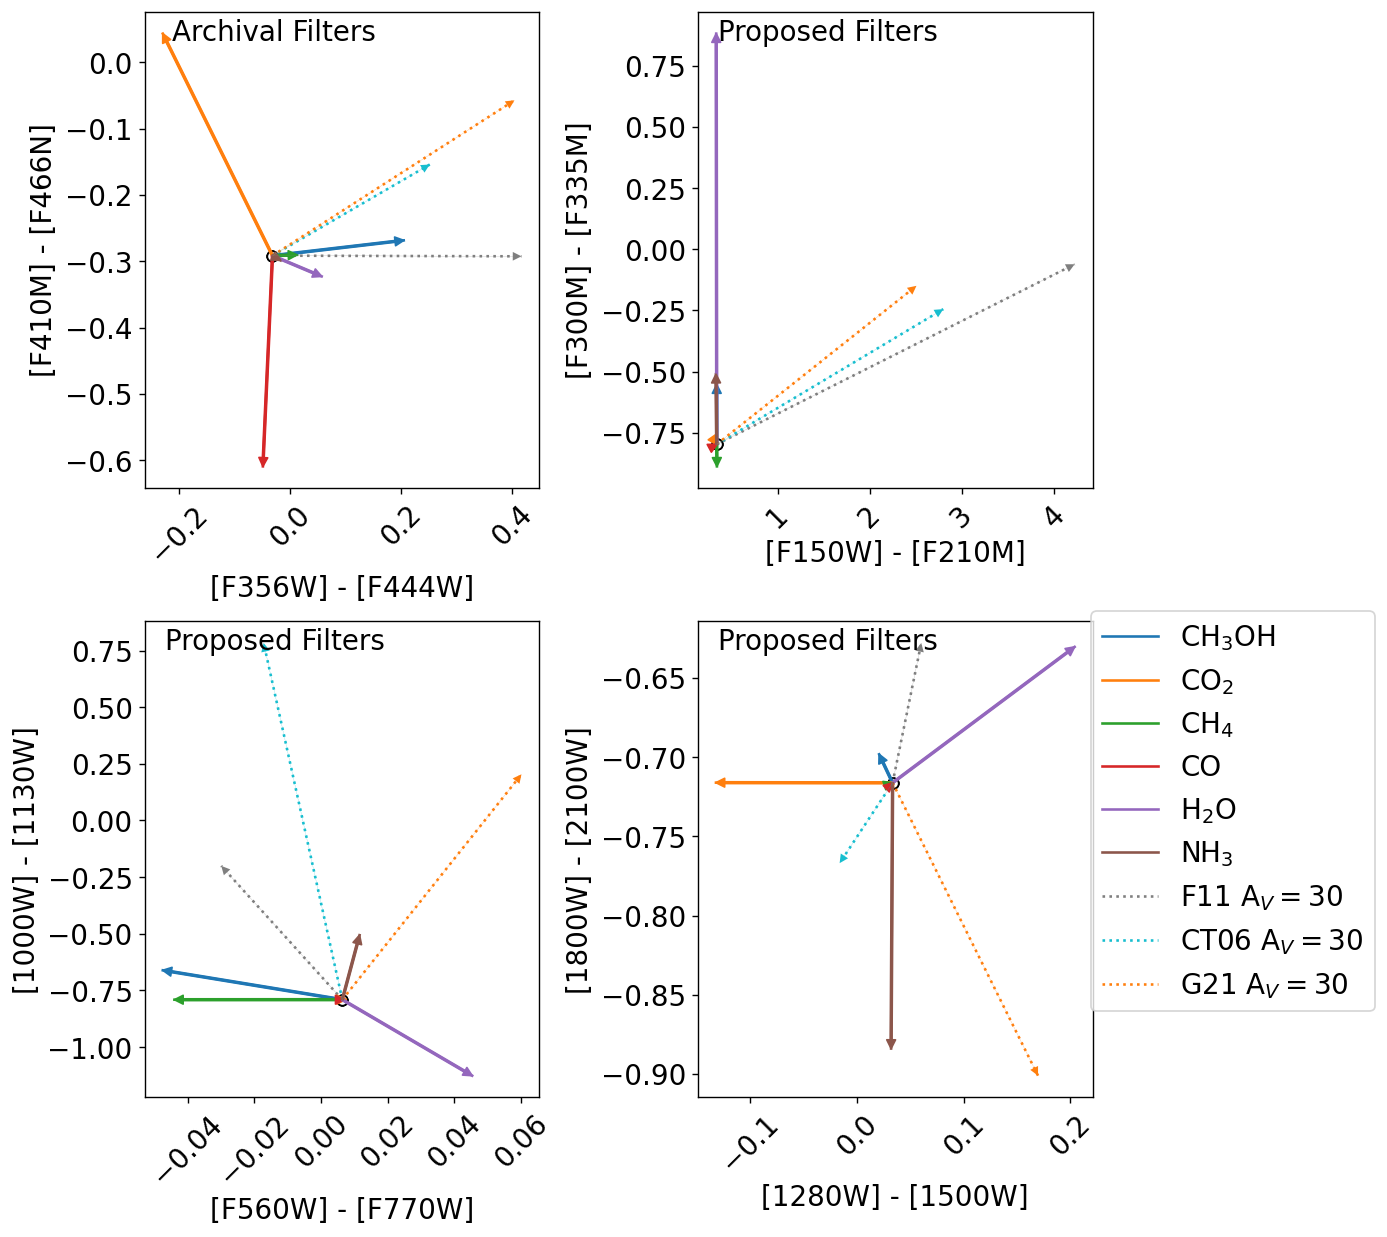

In [36]:
pl.figure(figsize=(12, 10), dpi=125)
#xarr = u.Quantity(phx4000['nu'],u.Hz).to(u.um, u.spectral())

temperature = 4000

with matplotlib.rc_context({'font.size': 16}):
    for ii, (cmd_x, cmd_y) in enumerate(cmds):
        ax = pl.subplot(2, 2, ii+1)
        ax.set_xlabel(f'[{cmd_x[0][-5:]}] - [{cmd_x[1][-5:]}]')
        ax.set_ylabel(f'[{cmd_y[0][-5:]}] - [{cmd_y[1][-5:]}]')

        
        xarr_ref = tmods[temperature]['nu'].quantity.to(u.um, u.spectral())
        flxd_ref = fluxes_in_filters(xarr, tmods[temperature]['fnu'].quantity)
        xs,ys,us,vs,cs = [],[],[],[],[]
        for (molecule, moldata), color in zip(molecule_data.items(),
                                            pl.rcParams['axes.prop_cycle'].by_key()['color']):
            consts = load_molecule(molecule)
            xdata = []
            ydata = []
            xarr = tmods[temperature]['nu'].quantity.to(u.um, u.spectral())
            spec = absorbed_spectrum(5e18*u.cm**-2, consts, molecular_weight=md['molwt'],
                                      spectrum=tmods[temperature]['fnu'].quantity,
                                      xarr=xarr,
                                     )

            flxd = fluxes_in_filters(xarr, spec)
            mags_x_star = (-2.5*np.log10(flxd_ref[cmd_x[0]] / u.Quantity(jfilts.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
                           -2.5*np.log10(flxd_ref[cmd_x[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            mags_y_star = (-2.5*np.log10(flxd_ref[cmd_y[0]] / u.Quantity(jfilts.loc[cmd_y[0]]['ZeroPoint'], u.Jy)),
                           -2.5*np.log10(flxd_ref[cmd_y[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            xdata.append(mags_x_star[0]-mags_x_star[1])
            ydata.append(mags_y_star[0]-mags_y_star[1])
            mags_x = (-2.5*np.log10(flxd[cmd_x[0]] / u.Quantity(jfilts.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
                      -2.5*np.log10(flxd[cmd_x[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            mags_y = (-2.5*np.log10(flxd[cmd_y[0]] / u.Quantity(jfilts.loc[cmd_y[0]]['ZeroPoint'], u.Jy)),
                      -2.5*np.log10(flxd[cmd_y[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            xdata.append(mags_x[0]-mags_x[1])
            ydata.append(mags_y[0]-mags_y[1])
            #ax.scatter(xdata, ydata, color=pl.cm.jet(temperatures), label=molecule)
            L, = ax.plot(xdata, ydata, label=label_map[molecule])
            arrow_start = xdata[0], ydata[0]
            arrow_end = xdata[1], ydata[1]
            ax.annotate('', arrow_end, arrow_start,
                        arrowprops=dict(width=1, headwidth=5, headlength=5,
                        edgecolor=L.get_color(),
                        facecolor=L.get_color(),
                                       ),
                        color=L.get_color(),
                       )
            #L.set_visible(False) # hide these, but force the ax lims?
            #dx = pl.xlim()[1] - pl.xlim()[0]
            #ax.arrow(xdata[0], ydata[0], xdata[1]-xdata[0], ydata[1]-ydata[0])#, width=dx/30)
            xs.append(xdata[0])
            ys.append(ydata[0])
            us.append(xdata[1]-xdata[0])
            vs.append(ydata[1]-ydata[0])
            cs.append(color)
            #ax.set_xticklabels(rotation=45) # https://stackoverflow.com/questions/10998621/rotate-axis-text-in-python-matplotlib
            ax.tick_params(axis='x', labelrotation=45)
            #print(xdata, ydata)
            #for marker, temperature, xx, yy in zip('xos^p+', temperatures, xdata, ydata):
            #    ax.scatter(xx, yy, marker=marker, color=L.get_color())
            #print(xx, yy)
        for ext, extname in zip((F11_MWGC(), CT06_MWGC(), G21_MWAvg()),
                                ('F11', 'CT06', 'G21'),
                               ):
            slc = ((xarr > (u.Quantity(ext.x_range, u.um**-1).to(xarr.unit, u.spectral())).min()) &
                   (xarr < (u.Quantity(ext.x_range, u.um**-1).to(xarr.unit, u.spectral())).max()))
            attenuation = 10**(-ext(xarr[slc]) * av / 2.5)
            extspec = spec[slc] * attenuation
            flxd_ext = fluxes_in_filters(xarr[slc], extspec)
            xdata = [mags_x_star[0]-mags_x_star[1]]
            ydata = [mags_y_star[0]-mags_y_star[1]]
            ax.plot(xdata, ydata, marker='o', markerfacecolor='w', markeredgecolor='k', zorder=-10)
            mags_x = (-2.5*np.log10(flxd_ext[cmd_x[0]] / u.Quantity(jfilts.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
                      -2.5*np.log10(flxd_ext[cmd_x[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            mags_y = (-2.5*np.log10(flxd_ext[cmd_y[0]] / u.Quantity(jfilts.loc[cmd_y[0]]['ZeroPoint'], u.Jy)),
                      -2.5*np.log10(flxd_ext[cmd_y[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            xdata.append(mags_x[0]-mags_x[1])
            ydata.append(mags_y[0]-mags_y[1])
            L, = ax.plot(xdata, ydata, label=f'{extname} A$_V={av}$', linestyle=':')
            #L.set_visible(False)
            arrow_start = xdata[0], ydata[0]
            arrow_end = xdata[1], ydata[1]
            ax.annotate('', arrow_end, arrow_start,
                        arrowprops=dict(width=0.1, headwidth=5, headlength=5,
                                        edgecolor='none', #L.get_color(),
                                        facecolor=L.get_color(),
                                        linestyle=':',
                                       ),
                        color=L.get_color(),
                        #label=f'{extname} A$_V={av}$',
                       )
        # can't label with quiver.
        # ax.quiver(xs, ys, us, vs, np.arange(len(xs)), angles='xy', cmap='rainbow',
        #           scale_units='xy',
        #           scale=1,
        #          )
        # https://stackoverflow.com/questions/45148539/project-variables-in-pca-plot-in-python
        #dx = pl.xlim()[1] - pl.xlim()[0]
        #for arrow in ax.patches:
        #    arrow.set_data(width=dx/50)
        
        if ii == 0:
            ax.text(0.07, 0.94, "Archival Filters", transform=ax.transAxes)
        else:
            ax.text(0.05, 0.94, "Proposed Filters", transform=ax.transAxes)

    pl.legend(loc='upper right', bbox_to_anchor=[1.75,1.05])
    #pl.suptitle("N(ice) = $5\\times10^{18}$ cm$^{-2}$")
pl.tight_layout()
pl.savefig("IceColors_NIRCAM_MIRI_multiext.png", bbox_inches='tight')

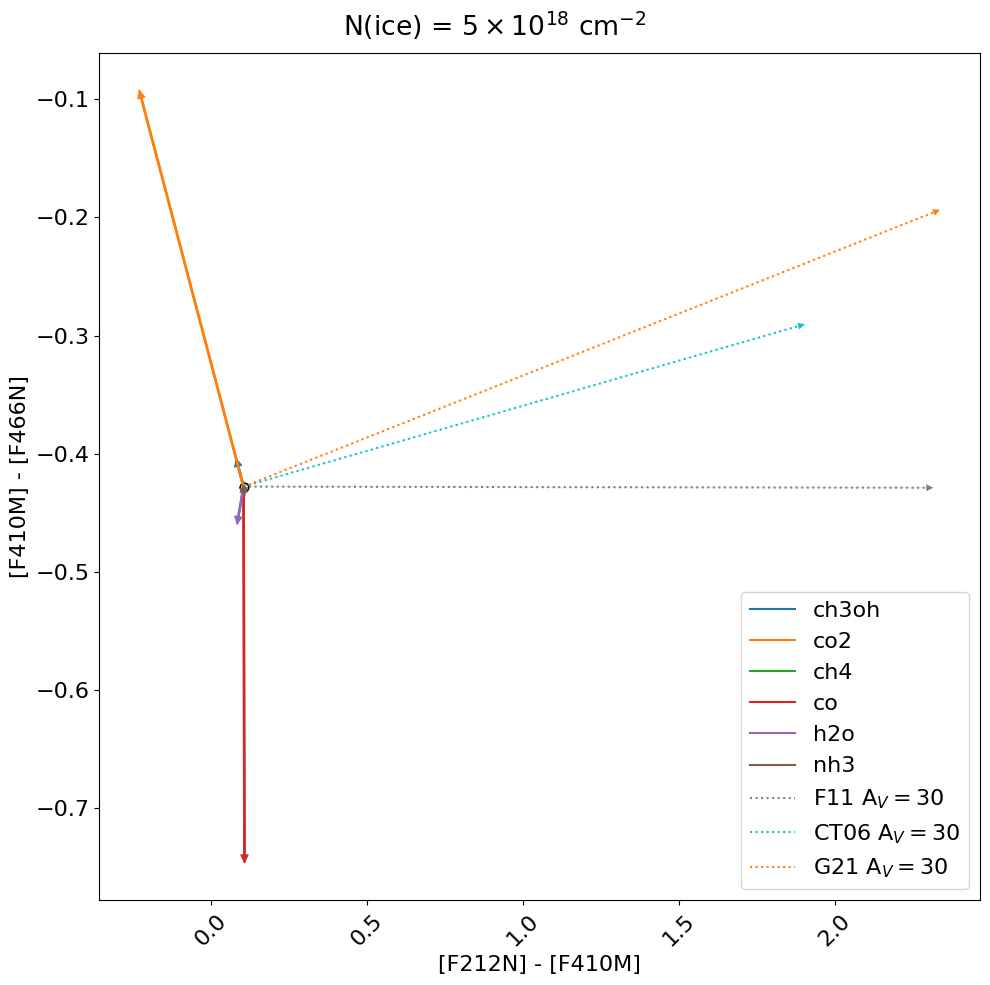

In [37]:
ccds2 = [
    (('JWST/NIRCam.F212N', 'JWST/NIRCam.F410M'),
     ('JWST/NIRCam.F410M', 'JWST/NIRCam.F466N')),
# no ice    (('JWST/NIRCam.F187N', 'JWST/NIRCam.F182M'),
# no ice     ('JWST/NIRCam.F182M', 'JWST/NIRCam.F212N')),

]    

temperature = 4000

pl.figure(figsize=(10, 10), dpi=100)
#xarr = u.Quantity(phx4000['nu'],u.Hz).to(u.um, u.spectral())


with matplotlib.rc_context({'font.size': 16}):
    for ii, (cmd_x, cmd_y) in enumerate(ccds2):
        ax = pl.subplot(1, 1, ii+1)
        ax.set_xlabel(f'[{cmd_x[0][-5:]}] - [{cmd_x[1][-5:]}]')
        ax.set_ylabel(f'[{cmd_y[0][-5:]}] - [{cmd_y[1][-5:]}]')

        
        xarr_ref = tmods[temperature]['nu'].quantity.to(u.um, u.spectral())
        flxd_ref = fluxes_in_filters(xarr, tmods[temperature]['fnu'].quantity)
        xs,ys,us,vs,cs = [],[],[],[],[]
        for (molecule, moldata), color in zip(molecule_data.items(),
                                            pl.rcParams['axes.prop_cycle'].by_key()['color']):
            consts = load_molecule(molecule)
            xdata = []
            ydata = []
            xarr = tmods[temperature]['nu'].quantity.to(u.um, u.spectral())
            spec = absorbed_spectrum(5e18*u.cm**-2, consts, molecular_weight=md['molwt'],
                                      spectrum=tmods[temperature]['fnu'].quantity,
                                      xarr=xarr,
                                     )

            flxd = fluxes_in_filters(xarr, spec)
            mags_x_star = (-2.5*np.log10(flxd_ref[cmd_x[0]] / u.Quantity(jfilts.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
                           -2.5*np.log10(flxd_ref[cmd_x[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            mags_y_star = (-2.5*np.log10(flxd_ref[cmd_y[0]] / u.Quantity(jfilts.loc[cmd_y[0]]['ZeroPoint'], u.Jy)),
                           -2.5*np.log10(flxd_ref[cmd_y[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            xdata.append(mags_x_star[0]-mags_x_star[1])
            ydata.append(mags_y_star[0]-mags_y_star[1])
            mags_x = (-2.5*np.log10(flxd[cmd_x[0]] / u.Quantity(jfilts.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
                      -2.5*np.log10(flxd[cmd_x[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            mags_y = (-2.5*np.log10(flxd[cmd_y[0]] / u.Quantity(jfilts.loc[cmd_y[0]]['ZeroPoint'], u.Jy)),
                      -2.5*np.log10(flxd[cmd_y[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            xdata.append(mags_x[0]-mags_x[1])
            ydata.append(mags_y[0]-mags_y[1])
            #ax.scatter(xdata, ydata, color=pl.cm.jet(temperatures), label=molecule)
            L, = ax.plot(xdata, ydata, label=molecule)
            arrow_start = xdata[0], ydata[0]
            arrow_end = xdata[1], ydata[1]
            ax.annotate('', arrow_end, arrow_start,
                        arrowprops=dict(width=1, headwidth=5, headlength=5,
                        edgecolor=L.get_color(),
                        facecolor=L.get_color(),
                                       ),
                        color=L.get_color(),
                       )
            #L.set_visible(False) # hide these, but force the ax lims?
            #dx = pl.xlim()[1] - pl.xlim()[0]
            #ax.arrow(xdata[0], ydata[0], xdata[1]-xdata[0], ydata[1]-ydata[0])#, width=dx/30)
            xs.append(xdata[0])
            ys.append(ydata[0])
            us.append(xdata[1]-xdata[0])
            vs.append(ydata[1]-ydata[0])
            cs.append(color)
            #ax.set_xticklabels(rotation=45) # https://stackoverflow.com/questions/10998621/rotate-axis-text-in-python-matplotlib
            ax.tick_params(axis='x', labelrotation=45)
            #print(xdata, ydata)
            #for marker, temperature, xx, yy in zip('xos^p+', temperatures, xdata, ydata):
            #    ax.scatter(xx, yy, marker=marker, color=L.get_color())
            #print(xx, yy)
        for ext, extname in zip((F11_MWGC(), CT06_MWGC(), G21_MWAvg()),
                                ('F11', 'CT06', 'G21'),
                               ):
            slc = ((xarr > (u.Quantity(ext.x_range, u.um**-1).to(xarr.unit, u.spectral())).min()) &
                   (xarr < (u.Quantity(ext.x_range, u.um**-1).to(xarr.unit, u.spectral())).max()))
            attenuation = 10**(-ext(xarr[slc]) * av / 2.5)
            extspec = spec[slc] * attenuation
            flxd_ext = fluxes_in_filters(xarr[slc], extspec)
            xdata = [mags_x_star[0]-mags_x_star[1]]
            ydata = [mags_y_star[0]-mags_y_star[1]]
            ax.plot(xdata, ydata, marker='o', markerfacecolor='w', markeredgecolor='k', zorder=-10)
            mags_x = (-2.5*np.log10(flxd_ext[cmd_x[0]] / u.Quantity(jfilts.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
                      -2.5*np.log10(flxd_ext[cmd_x[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            mags_y = (-2.5*np.log10(flxd_ext[cmd_y[0]] / u.Quantity(jfilts.loc[cmd_y[0]]['ZeroPoint'], u.Jy)),
                      -2.5*np.log10(flxd_ext[cmd_y[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            xdata.append(mags_x[0]-mags_x[1])
            ydata.append(mags_y[0]-mags_y[1])
            L, = ax.plot(xdata, ydata, label=f'{extname} A$_V={av}$', linestyle=':')
            #L.set_visible(False)
            arrow_start = xdata[0], ydata[0]
            arrow_end = xdata[1], ydata[1]
            ax.annotate('', arrow_end, arrow_start,
                        arrowprops=dict(width=0.1, headwidth=5, headlength=5,
                                        edgecolor='none', #L.get_color(),
                                        facecolor=L.get_color(),
                                        linestyle=':',
                                       ),
                        color=L.get_color(),
                        #label=f'{extname} A$_V={av}$',
                       )
        # can't label with quiver.
        # ax.quiver(xs, ys, us, vs, np.arange(len(xs)), angles='xy', cmap='rainbow',
        #           scale_units='xy',
        #           scale=1,
        #          )
        # https://stackoverflow.com/questions/45148539/project-variables-in-pca-plot-in-python
        #dx = pl.xlim()[1] - pl.xlim()[0]
        #for arrow in ax.patches:
        #    arrow.set_data(width=dx/50)
        

    pl.legend(loc='best')#upper right', bbox_to_anchor=[1.00,1.05])
    pl.suptitle("N(ice) = $5\\times10^{18}$ cm$^{-2}$")
pl.tight_layout()
pl.savefig("IceColors_NIRCAM_MIRI_multiext_observed.png", bbox_inches='tight')

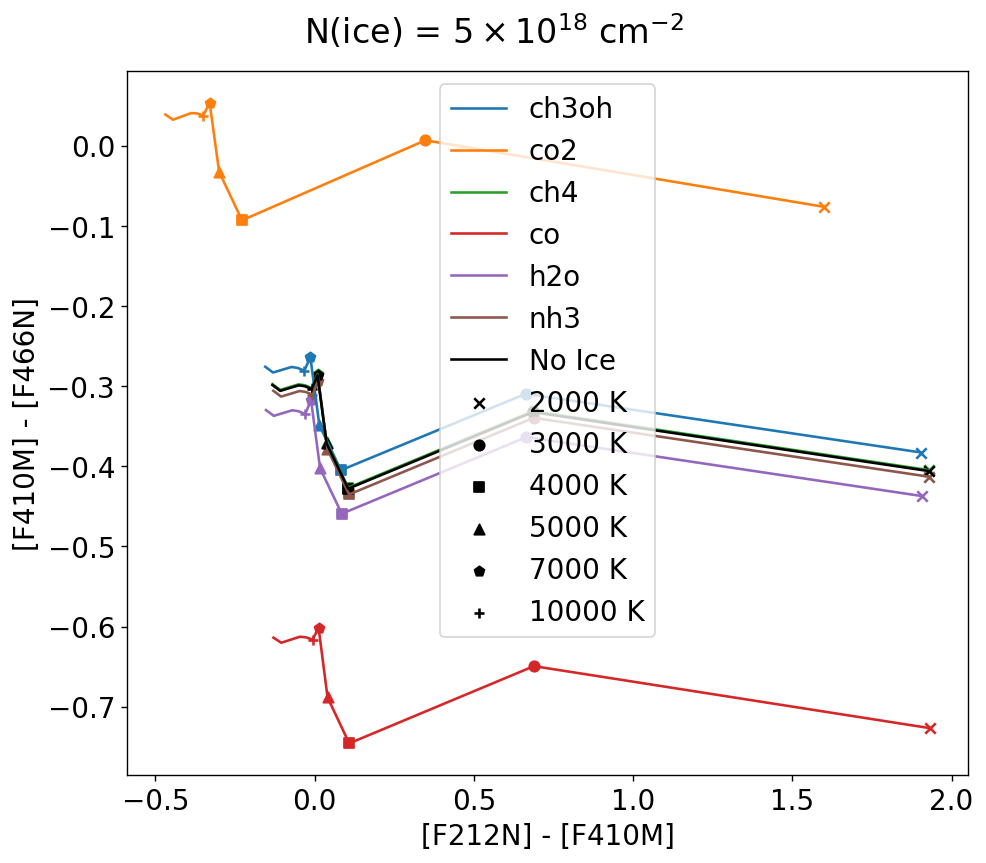

In [38]:
ccds2 = [
    (('JWST/NIRCam.F212N', 'JWST/NIRCam.F410M'),
     ('JWST/NIRCam.F410M', 'JWST/NIRCam.F466N')),
# no ice    (('JWST/NIRCam.F187N', 'JWST/NIRCam.F182M'),
# no ice     ('JWST/NIRCam.F182M', 'JWST/NIRCam.F212N')),

]    
pl.figure(figsize=(8, 7), dpi=125)
#xarr = u.Quantity(phx4000['nu'],u.Hz).to(u.um, u.spectral())


with matplotlib.rc_context({'font.size': 16}):
    for ii, (cmd_x, cmd_y) in enumerate(ccds2):
        ax = pl.subplot(1, 1, ii+1)
        ax.set_xlabel(f'[{cmd_x[0][-5:]}] - [{cmd_x[1][-5:]}]')
        ax.set_ylabel(f'[{cmd_y[0][-5:]}] - [{cmd_y[1][-5:]}]')

        
        for molecule, moldata in molecule_data.items():
            consts = load_molecule(molecule)
            xdata = []
            ydata = []
            for temperature in temperatures:
                xarr = tmods[temperature]['nu'].quantity.to(u.um, u.spectral())
                spec = absorbed_spectrum(5e18*u.cm**-2, consts, molecular_weight=md['molwt'],
                                          spectrum=tmods[temperature]['fnu'].quantity,
                                          xarr=xarr,
                                         )

                flxd = fluxes_in_filters(xarr, spec)
                mags_x = (-2.5*np.log10(flxd[cmd_x[0]] / u.Quantity(jfilts.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
                          -2.5*np.log10(flxd[cmd_x[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
                mags_y = (-2.5*np.log10(flxd[cmd_y[0]] / u.Quantity(jfilts.loc[cmd_y[0]]['ZeroPoint'], u.Jy)),
                          -2.5*np.log10(flxd[cmd_y[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
                xdata.append(mags_x[0]-mags_x[1])
                ydata.append(mags_y[0]-mags_y[1])
            #ax.scatter(xdata, ydata, color=pl.cm.jet(temperatures), label=molecule)
            L, = ax.plot(xdata, ydata, label=molecule)
            #print(xdata, ydata)
            for marker, temperature, xx, yy in zip('xos^p+', temperatures, xdata, ydata):
                ax.scatter(xx, yy, marker=marker, color=L.get_color())
                #print(xx, yy)

        xdata = []
        ydata = []
        for temperature in temperatures:
            xarr = tmods[temperature]['nu'].quantity.to(u.um, u.spectral())
            flxd = fluxes_in_filters(xarr, tmods[temperature]['fnu'].quantity)
            mags_x = (-2.5*np.log10(flxd[cmd_x[0]] / u.Quantity(jfilts.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
                      -2.5*np.log10(flxd[cmd_x[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            mags_y = (-2.5*np.log10(flxd[cmd_y[0]] / u.Quantity(jfilts.loc[cmd_y[0]]['ZeroPoint'], u.Jy)),
                      -2.5*np.log10(flxd[cmd_y[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            xdata.append(mags_x[0]-mags_x[1])
            ydata.append(mags_y[0]-mags_y[1])
        ax.plot(xdata, ydata, label='No Ice', color='k')
        for marker, temperature, xx, yy in zip('xos^p+', temperatures, xdata, ydata):
            ax.scatter(xx, yy, marker=marker, color='k', label=f'{temperature} K')
        

    pl.legend(loc='best')#upper right', bbox_to_anchor=[1.45,1.0])
    pl.suptitle("N(ice) = $5\\times10^{18}$ cm$^{-2}$")
pl.tight_layout()    

## SED model

For sensitivity estimation, how well can we detect stars at 8.5 kpc?  Behind A_K = 3?

In [39]:
temperature = 4000
xarr = tmods[temperature]['nu'].quantity.to(u.um, u.spectral())
slc = (xarr > 1.3*u.um) & (xarr < 27*u.um) # range supported by extinction tool

attenuation = 10**(-ext(xarr[slc]) * av / 2.5)
flxd = fluxes_in_filters(xarr[slc], tmods[temperature]['fnu'].quantity[slc] * attenuation)
flxd_unatten = fluxes_in_filters(xarr[slc], tmods[temperature]['fnu'].quantity[slc])
spec_allices = tmods[temperature]['fnu'].quantity[slc] * attenuation
spec_allices_noatten = tmods[temperature]['fnu'].quantity[slc]
for molecule, moldata in molecule_data.items():
    consts = load_molecule(molecule)
    spec_allices = absorbed_spectrum(5e18*u.cm**-2, consts, molecular_weight=md['molwt'],
                                     spectrum=spec_allices,
                                     xarr=xarr[slc],
                                    )
    spec_allices_noatten = absorbed_spectrum(5e18*u.cm**-2, consts, molecular_weight=md['molwt'],
                                     spectrum=spec_allices_noatten,
                                     xarr=xarr[slc],
                                    )
flxd_allices = fluxes_in_filters(xarr[slc], spec_allices)
flxd_allices_noatten = fluxes_in_filters(xarr[slc], spec_allices_noatten)

Text(0, 0.5, 'Flux [Jy]')

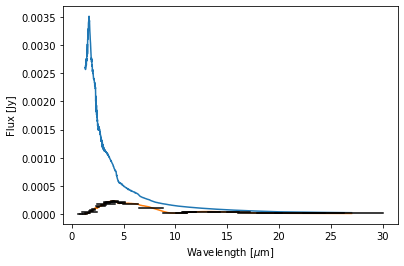

In [40]:
scalefactor = ((18*u.ABmag).to(u.Jy) / flxd['JWST/NIRCam.F410M']).decompose()
pl.plot(xarr[slc].to(u.um), (tmods[temperature]['fnu'].quantity[slc]).to(u.Jy) * scalefactor)
pl.plot(xarr[slc].to(u.um), (tmods[temperature]['fnu'].quantity[slc] * attenuation).to(u.Jy) * scalefactor)
for filterid in flxd:
    pl.plot(u.Quantity([filter_data.loc[filterid]['WavelengthMin']*u.AA, filter_data.loc[filterid]['WavelengthMax']*u.AA], u.um),
            u.Quantity([flxd[filterid], flxd[filterid]], u.Jy) * scalefactor,
            color='k')
pl.xlabel("Wavelength [$\\mu$m]")
pl.ylabel("Flux [Jy]")
#pl.ylim(0,0.32e2)

(1.0, 20.0, 1e-06, 0.001)

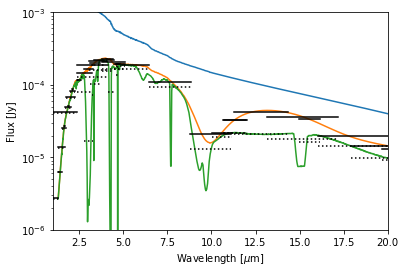

In [41]:
scalefactor = ((18*u.ABmag).to(u.Jy) / flxd['JWST/NIRCam.F410M']).decompose()
pl.plot(xarr[slc].to(u.um), (tmods[temperature]['fnu'].quantity[slc]).to(u.Jy) * scalefactor)
pl.plot(xarr[slc].to(u.um), (tmods[temperature]['fnu'].quantity[slc] * attenuation).to(u.Jy) * scalefactor)
pl.plot(xarr[slc].to(u.um), spec_allices.to(u.Jy) * scalefactor)
for filterid in flxd:
    pl.plot(u.Quantity([filter_data.loc[filterid]['WavelengthMin']*u.AA, filter_data.loc[filterid]['WavelengthMax']*u.AA], u.um),
            u.Quantity([flxd[filterid], flxd[filterid]], u.Jy) * scalefactor,
            color='k')
    pl.plot(u.Quantity([filter_data.loc[filterid]['WavelengthMin']*u.AA, filter_data.loc[filterid]['WavelengthMax']*u.AA], u.um),
            u.Quantity([flxd_allices[filterid], flxd_allices[filterid]], u.Jy) * scalefactor,
            color='k', linestyle=':')
pl.xlabel("Wavelength [$\\mu$m]")
pl.ylabel("Flux [Jy]")
pl.semilogy();
pl.axis([1,20,1e-6,1e-3])

(1.0, 20.0, 1e-06, 0.001)

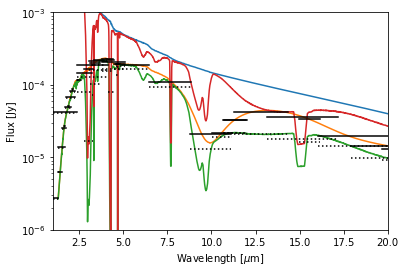

In [42]:
scalefactor = ((18*u.ABmag).to(u.Jy) / flxd['JWST/NIRCam.F410M']).decompose()
pl.plot(xarr[slc].to(u.um), (tmods[temperature]['fnu'].quantity[slc]).to(u.Jy) * scalefactor)
pl.plot(xarr[slc].to(u.um), (tmods[temperature]['fnu'].quantity[slc] * attenuation).to(u.Jy) * scalefactor)
pl.plot(xarr[slc].to(u.um), spec_allices.to(u.Jy) * scalefactor)
pl.plot(xarr[slc].to(u.um), spec_allices_noatten.to(u.Jy) * scalefactor)
for filterid in flxd:
    pl.plot(u.Quantity([filter_data.loc[filterid]['WavelengthMin']*u.AA, filter_data.loc[filterid]['WavelengthMax']*u.AA], u.um),
            u.Quantity([flxd[filterid], flxd[filterid]], u.Jy) * scalefactor,
            color='k')
    pl.plot(u.Quantity([filter_data.loc[filterid]['WavelengthMin']*u.AA, filter_data.loc[filterid]['WavelengthMax']*u.AA], u.um),
            u.Quantity([flxd_allices[filterid], flxd_allices[filterid]], u.Jy) * scalefactor,
            color='k', linestyle=':')
pl.xlabel("Wavelength [$\\mu$m]")
pl.ylabel("Flux [Jy]")
pl.semilogy();
pl.axis([1,20,1e-6,1e-3])

In [43]:
flxd['JWST/NIRCam.F410M'].to(u.Jy) * scalefactor.decompose()

<Quantity 0.00022909 Jy>

In [44]:
(18*u.ABmag).to(u.Jy)

<Quantity 0.00022909 Jy>

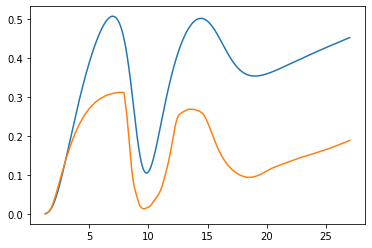

In [45]:
ext_ = G21_MWAvg().extinguish(xarr[slc], Av=30)
pl.plot(xarr[slc], ext_)
ext_ = CT06_MWGC().extinguish(xarr[slc], Av=30)
pl.plot(xarr[slc], ext_)

# Star Color Models for JWST White Paper

In [46]:
atmo_model(30000, np.linspace(1.7, 5.1, 5000)*u.um)

fnu,nu
erg / (Hz s cm2),Hz
float64,float64
1.2883430709461979e-17,176348504705882.34
1.2869279910316507e-17,176277979409059.38
1.2855140425022036e-17,176207510498642.0
1.2841012240015514e-17,176137097907034.16
1.2826895341755552e-17,176066741566747.75
1.281278971672239e-17,175996441410402.47
1.2798695351417849e-17,175926197370725.6
1.2784612232365291e-17,175856009380551.72


In [47]:
from astropy.modeling.models import BlackBody
from astropy.visualization import simple_norm
import matplotlib.colors

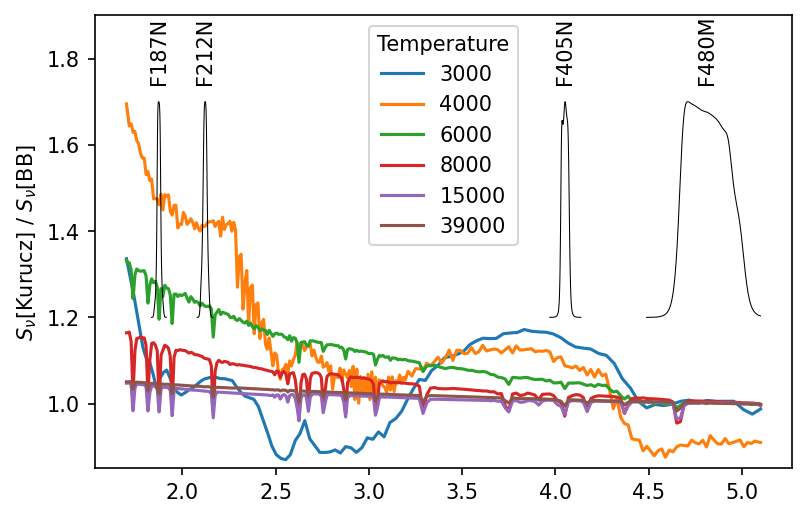

In [48]:
pl.figure(dpi=150)
for tem in (3000, 4000, 6000, 8000, 15000,  39000):
    mod = atmo_model(tem, np.linspace(1.7, 5.1, 5000)*u.um)
    lam = mod['nu'].quantity.to(u.um, u.spectral())
    sp = (mod['fnu']/mod['fnu'].max()*lam**2).value
    sp /= sp.max()
    #L, = pl.plot(lam, sp, label=str(tem))
    
    bb = BlackBody(tem*u.K)(lam)*u.sr
    spbb = ((bb/bb.max()*lam**2).value)
    spbb /= spbb.max()
    #pl.plot(lam, spbb * sp.max(), color=L.get_color(), linewidth=0.5, linestyle='--')
    pl.plot(lam, sp / spbb, label=str(tem))
    
toplot = ['F187N', 'F212N', 'F405N', 'F480M']
for filtername in toplot:
    fname = f'JWST/NIRCam.{filtername}'
    row = filter_data.loc[fname]
    color ='k'
        
    pl.text(u.Quantity(row['WavelengthEff'], u.AA).to(u.um).value,
            1.75, fname.split(".")[-1], rotation=90, 
            horizontalalignment='center',
            color=color
           )
    trans = SvoFps.get_transmission_data(row['filterID'])
    pl.plot(trans['Wavelength'].quantity.to(u.um),
            trans['Transmission'].value/trans['Transmission'].value.max()/2 + 1.2,
            linewidth=0.5, color=color)
    
#pl.ylabel(r'$\lambda^2 S_{\nu} $')
pl.ylabel(r'$S_{\nu} $[Kurucz] / $S_{\nu}$[BB]')
#pl.ylim(0.65, 1.15)
pl.ylim(0.85, 1.9);
leg = pl.legend(loc='best')
leg.set_title("Temperature")

In [49]:
temperatures

(2000, 3000, 4000, 5000, 7000, 10000, 12000, 15000, 25000, 39000)

In [50]:
filter_data.loc[f'JWST/NIRCam.{filtername}']['WavelengthEff']

48139.105123907

In [51]:
temperatures = (2000, 2500, 3000, 3500, 4000, 4500, 5000, 7000, 10000, 12000, 15000, 25000, 39000)

xarr = np.concatenate([SvoFps.get_transmission_data(f'JWST/NIRCam.{filtername}')['Wavelength'].quantity
                       for filtername in ['F187N', 'F212N', 'F405N', 'F480M']])

tmods = {temperature: atmo_model(temperature, xarr=xarr)
         for temperature in temperatures}

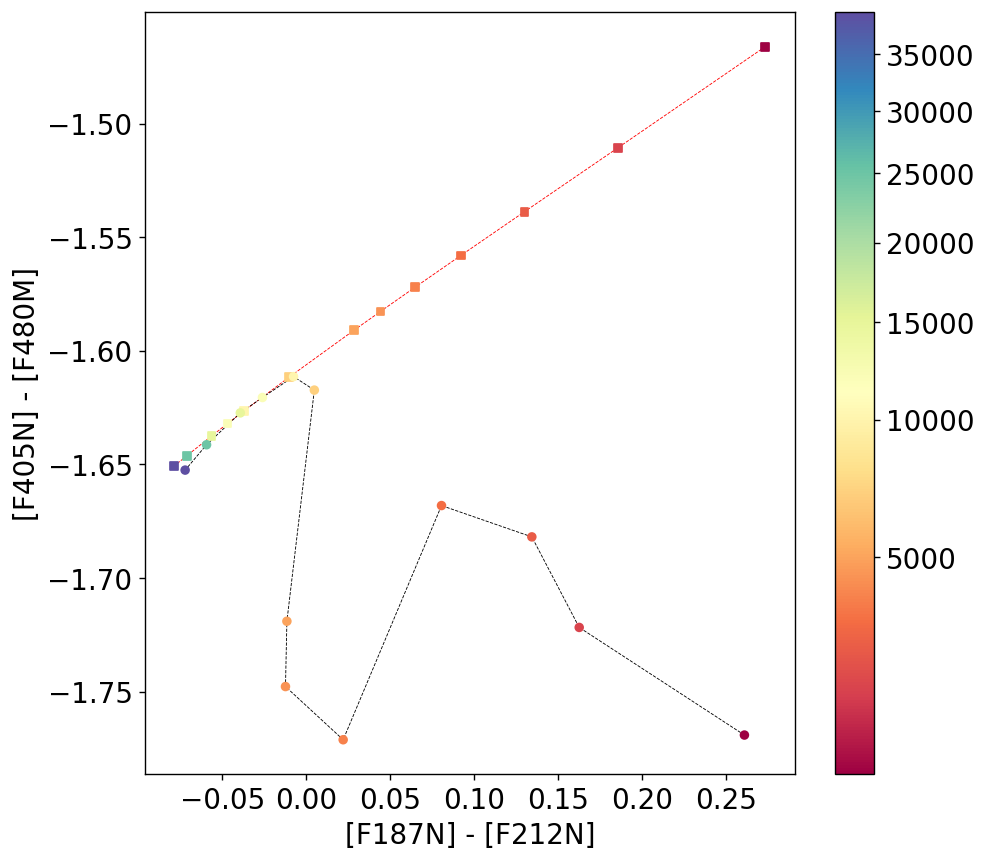

In [52]:
ccds2 = [
    (('JWST/NIRCam.F187N', 'JWST/NIRCam.F212N'),
     ('JWST/NIRCam.F405N', 'JWST/NIRCam.F480M')),
# no ice    (('JWST/NIRCam.F187N', 'JWST/NIRCam.F182M'),
# no ice     ('JWST/NIRCam.F182M', 'JWST/NIRCam.F212N')),

]    
pl.figure(figsize=(8, 7), dpi=125)
#xarr = u.Quantity(phx4000['nu'],u.Hz).to(u.um, u.spectral())

temperatures = (2000, 2500, 3000, 3500, 4000, 4500, 5000, 7000, 10000, 12000, 15000, 25000, 39000)

xarr = np.concatenate([SvoFps.get_transmission_data(f'JWST/NIRCam.{filtername}')['Wavelength'].quantity
                       for filtername in ['F187N', 'F212N', 'F405N', 'F480M']])

tmods = {temperature: atmo_model(temperature, xarr=xarr)
         for temperature in temperatures}

cmap = 'Spectral'
with matplotlib.rc_context({'font.size': 16}):
    for ii, (cmd_x, cmd_y) in enumerate(ccds2):
        ax = pl.subplot(1, 1, ii+1)
        ax.set_xlabel(f'[{cmd_x[0][-5:]}] - [{cmd_x[1][-5:]}]')
        ax.set_ylabel(f'[{cmd_y[0][-5:]}] - [{cmd_y[1][-5:]}]')

        
        xdata = []
        ydata = []
        for temperature in temperatures:
            xarr = tmods[temperature]['nu'].quantity.to(u.um, u.spectral())
            flxd = fluxes_in_filters(xarr, tmods[temperature]['fnu'].quantity)
            mags_x = (-2.5*np.log10(flxd[cmd_x[0]] / u.Quantity(jfilts.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
                      -2.5*np.log10(flxd[cmd_x[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            mags_y = (-2.5*np.log10(flxd[cmd_y[0]] / u.Quantity(jfilts.loc[cmd_y[0]]['ZeroPoint'], u.Jy)),
                      -2.5*np.log10(flxd[cmd_y[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            xdata.append(mags_x[0]-mags_x[1])
            ydata.append(mags_y[0]-mags_y[1])
            
        ax.plot(xdata, ydata, label='Kurucz', color='k', linewidth=0.5, linestyle='--', zorder=-9)
        sc = ax.scatter(xdata, ydata, c=temperatures, cmap=cmap, s=20, norm=simple_norm(temperatures, stretch='sqrt'))
        
        xdata = []
        ydata = []
        for tem in temperatures:
            bb = BlackBody(tem*u.K)
            flxd = fluxes_in_filters(xarr, bb(xarr)*u.sr)
            mags_x = (-2.5*np.log10(flxd[cmd_x[0]] / u.Quantity(jfilts.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
                      -2.5*np.log10(flxd[cmd_x[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            mags_y = (-2.5*np.log10(flxd[cmd_y[0]] / u.Quantity(jfilts.loc[cmd_y[0]]['ZeroPoint'], u.Jy)),
                      -2.5*np.log10(flxd[cmd_y[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
            #ax.scatter(mags_x[0]-mags_x[1], mags_y[0]-mags_y[1], marker='x', s=25, color='k')
            xdata.append(mags_x[0]-mags_x[1])
            ydata.append(mags_y[0]-mags_y[1])
            
        ax.plot(xdata, ydata, label='Pure Blackbody', color='r', linewidth=0.5, linestyle='--', zorder=-10)
        sc1 = ax.scatter(xdata, ydata, c=temperatures, cmap=cmap, s=20, marker='s', norm=simple_norm(temperatures, stretch='sqrt'), zorder=-5)
        
        
        #for marker, temperature, xx, yy in zip('xos^p+hv>d<8HXD', temperatures, xdata, ydata):
        #    sc1 = ax.scatter(xx, yy, marker=marker, color='k', label=f'{temperature} K')
        #    sc1.set_facecolor('none')
        #    sc1.set_edgecolor('k')
        

    cb = pl.colorbar(mappable=sc)
    #pl.legend(loc='best')#upper right', bbox_to_anchor=[1.45,1.0])
    #pl.suptitle("N(ice) = $5\\times10^{18}$ cm$^{-2}$")
pl.tight_layout()    

(4, 4.1)

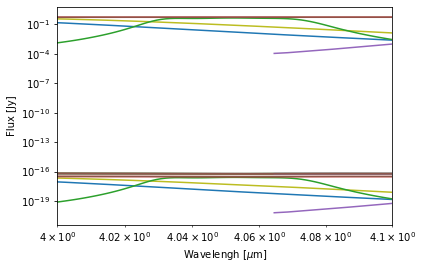

In [53]:
temperature = 10000
flxd = fluxes_in_filters(xarr, tmods[temperature]['fnu'].quantity, doplot=True)
pl.xlim(4, 4.1)

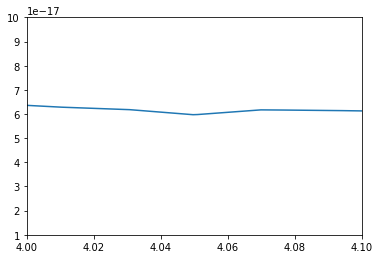

In [54]:
pl.plot(xarr.to(u.um), tmods[temperature]['fnu'].quantity,)
pl.xlim(4, 4.1)
pl.ylim(1e-17, 1e-16);

(2e-16, 2.6e-16)

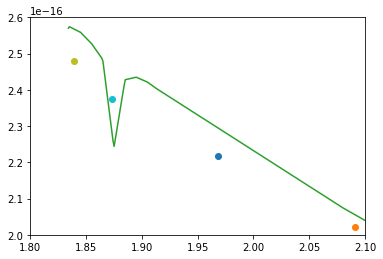

In [55]:
temperature = 10000
flxd = fluxes_in_filters(xarr, tmods[temperature]['fnu'].quantity)
for filtername in flxd:
    pl.plot(filter_data.loc[filtername]['WavelengthEff'] / 1e4, flxd[filtername], 'o')
pl.plot(xarr.to(u.um), tmods[temperature]['fnu'].quantity)
pl.xlim(1.8, 2.1); pl.ylim(2e-16, 2.6e-16)

(2e-17, 2e-16)

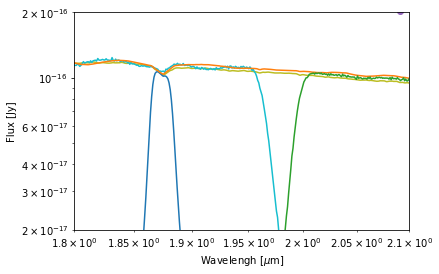

In [56]:
temperature = 10000
flxd = fluxes_in_filters(xarr, tmods[temperature]['fnu'].quantity, doplot=True)
for filtername in flxd:
    pl.plot(filter_data.loc[filtername]['WavelengthEff'] / 1e4, flxd[filtername], 'o')
pl.plot(xarr.to(u.um), tmods[temperature]['fnu'].quantity)
pl.xlim(1.8, 2.1); pl.ylim(2e-17, 2e-16)